In [1]:
import numpy as np
import numpy.matlib
from numpy.linalg import LinAlgError
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import SplineTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import seaborn as sns
from cycler import cycler
%matplotlib inline

2024-11-04 21:15:37.840181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 21:15:37.953797: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from scipy import stats, ndimage
import dill
from copy import deepcopy
import cmocean
import time
from datetime import datetime
import json
import warnings

from statsmodels.formula.api import mixedlm

import os
import sys
sys.path.append('../GLM_Tensorflow_2/code')
import glm_class as glm

sys.path.append('../utils')
from paths import *
from db import select_db, get_db_info, execute_sql, insert_into_db, NumpyEncoder
from matio import loadmat
from protocols import load_params
from plotting import plot_stars, hide_spines, get_mouse_colors

from load_processed import load_processed
from analysisUtils import construct_where_str, assign_str_regions_from_kim
from glm_utils import *

sys.path.append('../behavior_analysis')
from traceUtils import check_stats

import joblib

In [3]:
plt.style.use('paper_export')
fmts = ['pdf', 'png']

### Load ephys sessions for all protocols

In [4]:
paths = get_db_info()
activity_type = 'spks'
table = 'ephys'

manipulation = '6-OHDA'  # 'combined'  # 
protocols = ['SameRewDist']  #, 'Bernoulli', 'DiverseDists', 'SameRewVar']  #, 'DistributionalRL_6Odours']  #, 'SameRewSize']

min_size = 10
cutoff = .01

prot_colors = []
tt_names = []
all_neuron_info = pd.DataFrame()

In [5]:
if table == 'ephys':
    if manipulation == '6-OHDA':
        class_name = 'lesion'
        class_labels = ['control', 'lesioned']
        cls_palette = {'control': '#005363', 'lesioned': '#FF69B4'}
        # macro_palette = {'Ventral': 'k'}
    else:
        class_name = 'str_regions'
        class_labels = assign_str_regions_from_kim(None)
        class_labels = list(class_labels.keys())
        class_labels.remove('mAcbSh')
        cls_palette = {roi: plt.cm.plasma(i / (len(class_labels))) for i, roi in enumerate(class_labels)}
    macro_palette = {'Ventral': plt.cm.plasma(1 / len(class_labels)), 'Dorsal': plt.cm.plasma((len(class_labels) - 2) / len(class_labels))}
    macro_regions = ['Ventral', 'Dorsal']
    cell_types = ['MSN', 'FSI', 'TAN']
    
elif table == 'imaging':
    class_name = 'genotype'
    class_labels = ['D1-Cre', 'A2a-Cre']
    cls_palette = {'D1-Cre': '#FFA001', 'A2a-Cre': '#0A704E'}
    macro_palette = {'Ventral': 'k'}
    cell_types = ['MSN']

In [6]:
for protocol in protocols:
    colors, protocol_info, periods, kwargs = load_params(protocol)
    if protocol == 'SameRewDist' and table == 'ephys': kwargs['manipulation'] = manipulation
    prot_colors.append(colors['prot_color'])
    tt_names.append(protocol_info['trace_type_names'])
    
    # create SQL query based on keyword arguments passed to function
    _, sql = construct_where_str(protocol, kwargs, table)
    rets = execute_sql(sql, paths['db'])
    
    # deal with stats kwarg case, which requires reading in the entire JSONified string of the table
    alpha = periods['alpha']
    rets = check_stats(rets, kwargs['stats'], protocol_info['pairs_to_check'], alpha)

    save_path = os.path.join('..', 'neural-plots', 'pooled', 'preloaded', '_'.join([protocol, table, str(manipulation), activity_type, 'glm_neuron_info' + '.sav']))

    if os.path.exists(save_path):
        print('Found saved vars at {}'.format(save_path))
        with open(save_path, 'rb') as f:
            neuron_info = joblib.load(f)
    else:
        neuron_info = load_processed(table, activity_type, protocol, kwargs, rets, save_path, fast_load=True, only_neuron_info=True)

    if table == 'ephys':
        neuron_info, reg_labels = assign_str_regions_from_kim(neuron_info)
    else: 
        neuron_info = pd.DataFrame(neuron_info)
    
    neuron_info['protocol'] = protocol
    all_neuron_info = pd.concat([all_neuron_info, neuron_info])

all_neuron_info = all_neuron_info.reset_index()
tt_names = list(dict.fromkeys([x for subl in tt_names for x in subl]))

KeyError: 'remote_neural_fig_root'

### Load glm_fit

In [24]:
# fits_all = select_db('my', 'glm_fit', '*', 'TRUE', (), unique=False)
# fits_all = pd.DataFrame(fits_all)

In [25]:
if table == 'ephys':
    reg = 'group_lasso'
    se_frac = 0.75
    l1_ratio = 0.0  # not used, but in table
    # reg = 'elastic_net'
    # se_frac = 0
    # l1_ratio = 0.9
    dt = .020  # from streams/DataStream(). Will need to change if bin width changes!!
else:
    reg = 'group_lasso'
    se_frac = 0.75
    l1_ratio = 0.0
    dt = 1/15.24  # usual frame rate

# fits = select_db('my', 'glm_fit', '*', '(name=? AND exp_date=?) OR (name=? AND exp_date=?) AND se_frac=? AND l1_ratio=? AND regularization=? AND dt=? AND modality=?',
#                  ('AL36', 20211216, 'AL41', 20211024, se_frac, l1_ratio, reg, dt, table), unique=False)
fits = select_db('my', 'glm_fit', '*', 'se_frac=? AND l1_ratio=? AND regularization=? AND dt>? AND dt<? AND modality=?',
                 (se_frac, l1_ratio, reg, dt-.01, dt+.01, table), unique=False)
fits = pd.DataFrame(fits)

### Look at the statistical distribution of expectile levels (taus) with highest coefs, as well as their spatial distribution.

In [26]:
model_specs = select_db('my', 'glm_setup', '*', 'se_frac=? AND l1_ratio=? AND regularization=? AND dt>? AND dt<? AND modality=?', 
                        (se_frac, l1_ratio, reg, dt-.01, dt+.01, table), unique=False)
model_specs = pd.DataFrame(model_specs)
full_model_specs = model_specs[model_specs['dropped_out_vars'] == 'none']

In [27]:
len(np.unique(all_neuron_info['fig_paths']))

39

In [28]:
set(np.unique(fits['figure_path'])) - set(np.unique(full_model_specs['figure_path']))

{'/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/behavior-plots/AL28/20210415',
 '/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/behavior-plots/AL88/20230701'}

In [29]:
len(np.unique(full_model_specs['figure_path']))

230

In [30]:
fits.keys()

Index(['mid', 'name', 'sid', 'rid', 'figure_path', 'exp_date', 'i_cell',
       'se_frac', 'regularization', 'learning_rate', 'l1_ratio', 'dt',
       'lambda', 'lambda_ind', 'modality', 'null_dev', 'full_coefs',
       'full_dev', 'full_dev_expl', 'full_dev_abl_nuissance',
       'full_dev_expl_abl_nuissance', 'expectiles_coefs', 'expectiles_dev',
       'expectiles_dev_expl', 'expectiles_dev_abl_nuissance',
       'expectiles_dev_expl_abl_nuissance', 'expectiles_frac_expl_dev',
       'expectiles_frac_null_dev', 'licking_coefs', 'licking_dev',
       'licking_dev_expl', 'licking_dev_abl_nuissance',
       'licking_dev_expl_abl_nuissance', 'licking_frac_expl_dev',
       'licking_frac_null_dev', 'motor_coefs', 'motor_dev', 'motor_dev_expl',
       'motor_dev_abl_nuissance', 'motor_dev_expl_abl_nuissance',
       'motor_frac_expl_dev', 'motor_frac_null_dev', 'history_coefs',
       'history_dev', 'history_dev_expl', 'history_dev_abl_nuissance',
       'history_dev_expl_abl_nuissance', 

In [31]:
len(np.unique(fits['name']))

29

In [32]:
np.unique(full_model_specs['name'])

array(['AL101', 'AL102', 'AL104', 'AL105', 'AL23', 'AL24', 'AL25', 'AL26',
       'AL27', 'AL28', 'AL29', 'AL30', 'AL36', 'AL37', 'AL39', 'AL40',
       'AL41', 'AL47', 'AL49', 'AL54', 'AL55', 'AL77', 'AL79', 'AL81',
       'AL82', 'AL83', 'AL88', 'AL89', 'AL90'], dtype=object)

### Merge tables

In [33]:
if table == 'ephys':
    all_neuron_info['macro_regions'] = None
    all_neuron_info.loc[np.isin(all_neuron_info['str_regions'], ['OT', 'VP', 'mAcbSh', 'lAcbSh', 'core']), 'macro_regions'] = 'Ventral'
    all_neuron_info.loc[np.isin(all_neuron_info['str_regions'], ['VMS', 'VLS', 'DMS', 'DLS']), 'macro_regions'] = 'Dorsal'
else:
    all_neuron_info['macro_regions'] = 'Ventral'
    all_neuron_info['cell_types'] = 'MSN'


if manipulation == '6-OHDA':
    all_neuron_info['hemi'] = False
    all_neuron_info.loc[all_neuron_info['mls'] > 0, 'hemi'] = True

    all_neuron_info['lesion'] = None
    mice = np.unique(all_neuron_info['names'])
    lesion_rets = select_db(paths['db'], 'lesion', '*', 'lesion="6-OHDA"', (), unique=False)
    for lret in lesion_rets:
        if lret['name'] in mice:
            larea_mouse = np.logical_and.reduce([all_neuron_info.depths > lret['bregma_bottom'], 
                                                 all_neuron_info.depths < lret['bregma_top'],
                                                 all_neuron_info.names == lret['name']])
            all_neuron_info.loc[np.logical_and(larea_mouse, all_neuron_info.hemi), 'lesion'] = 'lesioned'
            all_neuron_info.loc[np.logical_and(larea_mouse, ~all_neuron_info.hemi), 'lesion'] = 'control'
    print('lesion marked')

lesion marked


In [34]:
merge = all_neuron_info.merge(fits, 'inner', left_on=['names', 'file_dates', 'neuron_idx_inc'], right_on=['name', 'exp_date', 'i_cell']).drop_duplicates(subset=['name', 'exp_date', 'i_cell'])
merge = merge.merge(full_model_specs[['name', 'exp_date', 'regressor_labels']], 'left', on=['name', 'exp_date']) 

In [35]:
mc = [get_mouse_colors(protocol, True) if table == 'imaging' else get_mouse_colors(protocol) for protocol in protocols]
mouse_colors = {k: v for d in mc for k, v in d.items()}
subs = ['all', 'history', 'expectiles', 'motor', 'reward']
subs_palette = {k: v for k, v in zip(subs, [[.3]*3, '#ef9b20', '#87bc45', '#b33dc6', '#85C1E9'])}
drop_vars = subs[1:]
drop_palette = [v for k, v in subs_palette.items() if k != 'all']

drop_abbrvs = ['h', 'e', 'm', 'r']
drop_tups = [(l, m) for i, l in enumerate(drop_abbrvs) for m in drop_abbrvs[:i]]

drop_tunings = ['abs_' + x if x == 'expectiles' else x for x in drop_vars]

In [37]:
np.unique(merge['name'])

array(['AL47', 'AL49', 'AL54', 'AL55', 'AL83'], dtype=object)

# Compute difference in deviance explained upon holding out expectiles (or motor or trial history), as well as the kernel magnitudes for each expectile

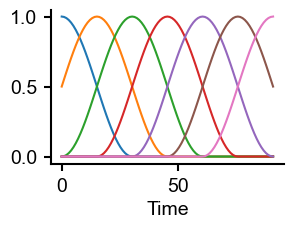

In [189]:
merge['trim_dev_expl'] = merge['full_dev_expl_abl_nuissance']
merge.loc[merge['trim_dev_expl'] < -1, 'trim_dev_expl'] = -1
# get filters, in order to compute kernels later
filts, pred_filts, filt_time = get_filts(dt)
n_filts = filts.shape[1]

n_bases = 7
nsamps_per_trial = int(np.around(6/dt))  # check that this is 91 in the imaging case and that this matches the neural data from DataStream
bases, basis_widths, basis_centers = create_basis(nsamps_per_trial, n_bases)
# basis_time = np.arange(-1, 5, dt)
basis_time = np.linspace(-1, 5, nsamps_per_trial)

# create columns for expectile tuning in merge df
taus = np.linspace(.1, .9, 5)
tau_strs = ['{:.1f}-tau tuning'.format(tau) for tau in taus]
merge[tau_strs] = np.nan
merge['pref_tau'] = np.nan

# create columns for history tuning in merge df
history_columns = [f'{n}-back {var}' for var in ['reward magnitude', 'mean', 'RPE'] for n in range(1, 3)]
merge[history_columns] = np.nan

# create columns for reward tuning in merge df
reward_columns = [f'{var}' for var in ['Reward present', 'Reward magnitude', 'RPE']]
merge[reward_columns] = np.nan

# create columns for motor tuning in merge df
all_conv_labels = ['Licking', 'running', 'whisking']
all_conv_columns = np.array([[conv_label + ' tuning', conv_label + '_pred tuning'] for conv_label in all_conv_labels], dtype=object).flatten()
merge[all_conv_columns] = np.nan

dir_labels = ['mot_svd', 'pupil']
merge[dir_labels] = np.nan
motor_candidates = dir_labels + all_conv_labels

# create dictionary to retain coefficients, for later dimensionality reduction/clustering
prot_coefs = {prot: {'coefs': [], 'labels': [], 'name': [], 'exp_date': [], 'figure_path': [], 
                     'i_cell': [], class_name: [], 'macro_regions': [], 'cell_types': []} for prot in protocols}
svd_coefs = {prot: {'coefs': np.empty((0, 50)), 'name': [], 'exp_date': [], 'figure_path': [],
                    'i_cell': [], class_name: [], 'macro_regions': [], 'cell_types': []} for prot in protocols}


In [190]:
# iterate through each full model
for i_row, row in full_model_specs.iterrows():
    # print(i_row)
    # get the relevant rows from merge
    merge_inds = np.logical_and(merge['name'] == row['name'], merge['exp_date'] == row['exp_date'])
    neurons = merge[merge_inds].reset_index(drop=True)
    # if the model has good_neurons associated with it (significant behavior session especially)
    if len(neurons) > 0:
        # get the labels for each regressor for that model, then group the labels in various ways with boolean arrays
        # which will be handy later
        labels = np.array(json.loads(row['regressor_labels']))
        expectile_labels = np.array(['expectile' in coef_name for coef_name in labels])
        history_labels = np.array(['-back' in coef_name for coef_name in labels])
        motor_groups = np.array([[candidate in coef_name for coef_name in labels] for candidate in motor_candidates])
        motor_labels = np.logical_or.reduce(motor_groups)
        # non_pupil_labels = np.array(['pupil' not in coef_name for coef_name in labels])
        mot_svd_labels = np.array(['mot_svd' in coef_name for coef_name in labels])
        reward_labels = np.array(['Reward' in coef_name or 'RPEfilt' in coef_name for coef_name in labels])

        # count number of expectile, motor, history, and reward groups
        n_expectiles = len(np.unique([lab[:-5] for lab in labels[expectile_labels]]))
        n_motor = np.sum([np.any(x) for x in motor_groups])
        n_history = len(np.unique([lab[:-5] for lab in labels[history_labels]]))
        n_reward = len(np.unique([lab[:-5] for lab in labels[reward_labels]]))

        # print(n_reward, labels[reward_labels])

        # extract all coefficients, row by row
        all_coefs = np.array([json.loads(neuron['full_coefs']) for _, neuron in neurons.iterrows()])

        # store coefficients, labels, and other info in prot_coefs dict. If pupil doesn't exist, make it zero
        # these are from neurons, which is from merge, so it only is using 'good cells'
        if np.any(mot_svd_labels):

            # to plot the decay of svd_coefs
            prot = neurons.loc[0, 'protocol']
            svd_coefs[prot]['coefs'] = np.vstack((svd_coefs[prot]['coefs'], np.abs(all_coefs[:, mot_svd_labels])))
            
            n_coefs_no_alter = list(labels).index('running_predfilt4') + 1
            # mot_svd_coefs = np.sum(np.abs(all_coefs[:, mot_svd_labels]), axis=1)
            pupil_coefs = np.zeros(all_coefs.shape[0]) if 'pupil' not in labels else all_coefs[:, list(labels).index('pupil')]

            # prot_c = np.hstack((all_coefs[:, :n_coefs_no_alter], mot_svd_coefs.reshape(-1, 1), pupil_coefs.reshape(-1, 1)))
            # prot_labels = np.concatenate((labels[:n_coefs_no_alter], ['mot_svd', 'pupil']))

            # DON'T include mot_svd for the coefficients since they're not aligned across sessions
            prot_c = np.hstack((all_coefs[:, :n_coefs_no_alter], pupil_coefs.reshape(-1, 1)))
            prot_labels = np.concatenate((labels[:n_coefs_no_alter], ['pupil']))
            
            prot_coefs[prot]['coefs'] = prot_c if len(prot_coefs[prot]['coefs']) == 0 else \
                np.vstack((prot_coefs[prot]['coefs'], prot_c))
            prot_coefs[prot]['labels'] = prot_labels.reshape(1, -1) if len(prot_coefs[prot]['labels']) == 0 else \
                np.vstack((prot_coefs[prot]['labels'], prot_labels.reshape(1, -1)))
            for key in ['name', 'exp_date', 'figure_path', 'i_cell', class_name, 'macro_regions', 'cell_types']:
                for use_dict in svd_coefs, prot_coefs:
                    # use_dict[prot][key].extend(np.repeat(row[key], neurons.shape[0]))
                    use_dict[prot][key].extend(neurons[key])
            # prot_coefs[prot]['i_cell'].extend(neurons['i_cell'])
            # prot_coefs[prot]['str_regions'].extend(neurons['str_regions'])
            # prot_coefs[prot]['macro_regions'].extend(neurons['macro_regions'])
        
        # extract specific coefficients
        expectile_coefs = all_coefs[:, expectile_labels]
        expectile_coefs_by_tau = expectile_coefs.reshape((neurons.shape[0], n_expectiles, n_filts))
        history_coefs = all_coefs[:, history_labels]
        history_coefs_by_var = history_coefs.reshape((neurons.shape[0], n_history, n_bases))
        reward_coefs = all_coefs[:, reward_labels]
        reward_coefs_by_var = reward_coefs.reshape((neurons.shape[0], n_reward, n_filts))
        motor_coefs = all_coefs[:, motor_labels]
        
        if n_expectiles == 1:  # SameRewSize protocol only has one expectile. NaN out the others
            expectile_coefs_by_tau = np.concatenate((np.full((neurons.shape[0], 2, n_filts), np.nan),
                                                     expectile_coefs_by_tau,
                                                     np.full((neurons.shape[0], 2, n_filts), np.nan)), axis=1)
        
        # compute expectile kernels for all neurons. For now, not taking absolute value
        expectile_expansion = filts[:, np.newaxis, np.newaxis, :] * expectile_coefs_by_tau[np.newaxis, :, :, :]
        # expectile_tuning = np.abs(np.sum(expectile_expansion, axis=3))  # sum over filters to get the kernel, then take the absolute value
        expectile_tuning = np.sum(expectile_expansion, axis=3)  # sum over filters to get the kernel
        expectile_int = np.trapz(expectile_tuning, x=filt_time, axis=0)  # integrate over time points to get an overall amount of tuning

        # compute history kernels for all neurons
        history_expansion = bases[:, np.newaxis, np.newaxis, :] * history_coefs_by_var[np.newaxis, :, :, :]
        history_tuning = np.sum(history_expansion, axis=3)  # sum over filters to get the kernel
        history_int = np.trapz(history_tuning, x=basis_time, axis=0)  # integrate over time points to get an overall amount of tuning

        reward_expansion = filts[:, np.newaxis, np.newaxis, :] * reward_coefs_by_var[np.newaxis, :, :, :]
        reward_tuning = np.sum(reward_expansion, axis=3)
        reward_int = np.trapz(reward_tuning, x=filt_time, axis=0)
        
        # compute motor kernels for all neurons where applicable, which is to say, Licking, Licking_pred, running, running_pred, 
        # whisking, and whisking_pred
        motor_expansion = np.empty((len(filt_time), neurons.shape[0], 0, n_filts))
        pred_labels = np.array(['pred' in coef_name for coef_name in labels[motor_labels]])
        conv_columns = []
        for conv_label in all_conv_labels:
            sub_labels = [conv_label in coef_name for coef_name in labels[motor_labels]]
            subpred_labels = np.logical_and(sub_labels, pred_labels)
            subresp_labels = np.logical_and(sub_labels, ~pred_labels)
            if np.sum(subpred_labels) == n_filts and np.sum(subresp_labels) == n_filts:
                conv_columns.extend([conv_label + ' tuning', conv_label + '_pred tuning'])
                pred_expansion = pred_filts[:, np.newaxis, np.newaxis, :] * motor_coefs[np.newaxis, :, np.newaxis, subpred_labels]
                resp_expansion = filts[:, np.newaxis, np.newaxis, :] * motor_coefs[np.newaxis, :, np.newaxis, subresp_labels]
                motor_expansion = np.concatenate((motor_expansion, pred_expansion, resp_expansion), axis=2)
        motor_tuning = np.sum(motor_expansion, axis=3)  # sum over filters to get the kernel
        motor_int = np.trapz(motor_tuning, x=filt_time, axis=0)  # integrate over time points to get an overall amount of tuning

        # add integrated kernels to merge df
        merge.loc[merge_inds, tau_strs] = expectile_int
        # merge.loc[merge_inds, 'pref_tau'] = taus[np.argmax(expectile_int, axis=1)]
        # merge.loc[merge_inds, 'pref_tau'] = np.sum(taus[np.newaxis, :] * expectile_int, axis=1) / np.sum(expectile_int, axis=1)
        # compute preferred tau, weighted by the absolute value of the integrated kernels
        merge.loc[merge_inds, 'pref_tau'] = np.sum(taus[np.newaxis, :] * np.abs(expectile_int), axis=1) / np.sum(np.abs(expectile_int), axis=1)

        merge.loc[merge_inds, history_columns] = history_int
        merge.loc[merge_inds, reward_columns[3-n_reward:]] = reward_int  # because Reward present, which is at index 0, is missing from Bernoulli
        
        merge.loc[merge_inds, conv_columns] = motor_int
        if 'pupil' in labels: merge.loc[merge_inds, 'pupil'] = all_coefs[:, list(labels).index('pupil')]
        if np.any(motor_groups[0]): merge.loc[merge_inds, 'mot_svd'] = np.sum(all_coefs[:, motor_groups[0]], axis=1) 

# compute total tuning as the sum across different taus
merge['total_expectiles_tuning'] = np.sum(merge[tau_strs], axis=1)
merge['total_abs_expectiles_tuning'] = np.abs(merge['total_expectiles_tuning'])
merge['sign_expectiles_tuning'] = np.sign(merge['total_expectiles_tuning'])

merge['total_history_tuning'] = np.sum(np.abs(merge[history_columns]), axis=1)
merge['total_reward_tuning'] = np.sum(np.abs(merge[reward_columns]), axis=1)

# for cols, name in zip([['pupil', 'mot_svd'], ['whisking tuning', 'whisking_pred tuning'], ['Licking tuning', 'Licking_pred tuning'], []],
#                       ['mot_svd_pupil', 'whisking', 'licking', 'orofacial', 'running', 
# compute the total motor tuning to different variables, taking the absolute value when necessary to ensure positive summation
merge['total_mot_svd_pupil_tuning'] = np.nansum(np.abs(merge[['pupil', 'mot_svd']]), axis=1)
merge['total_whisking_tuning'] = np.nansum(merge[['whisking tuning', 'whisking_pred tuning']], axis=1)
merge['total_licking_tuning'] = np.nansum(merge[['Licking tuning', 'Licking_pred tuning']], axis=1)
merge['total_whisking_licking_tuning'] = np.abs(merge['total_whisking_tuning']) + np.abs(merge['total_licking_tuning'])
merge['total_orofacial_tuning'] = merge['total_mot_svd_pupil_tuning'] + merge['total_whisking_licking_tuning']

merge['total_running_tuning'] = np.nansum(merge[['running tuning', 'running_pred tuning']], axis=1)
merge['total_conv_tuning'] = merge['total_whisking_licking_tuning'] + np.abs(merge['total_running_tuning'])
merge['total_motor_tuning'] = merge['total_orofacial_tuning'] + np.abs(merge['total_running_tuning'])
merge['frac_orofacial_tuning'] = merge['total_orofacial_tuning'] / merge['total_motor_tuning']

assert np.all([np.all(prot_coefs[protocol]['labels'][0] == prot_coefs[protocol]['labels']) for protocol in protocols])

In [191]:
for label in ['expectiles', 'motor', 'history', 'reward']:
    merge[f'{label}_trim_dev_expl'] = merge[f'{label}_dev_expl_abl_nuissance']
    merge.loc[merge[f'{label}_trim_dev_expl'] < -1, f'{label}_trim_dev_expl'] = -1
    merge[f'{label}_diff'] = merge['trim_dev_expl'] - merge[f'{label}_trim_dev_expl']
    merge[f'{label}_inds'] = np.logical_and.reduce([merge[f'{label}_diff'] > .01, merge[f'{label}_trim_dev_expl'] > 0, 
                                                    np.abs(merge[f'total_{label}_tuning']) > .1])

In [192]:
merge

index names  file_dates  neuron_idx_inc  \
0         0  AL60    20220427               0   
1         1  AL60    20220427               1   
2         2  AL60    20220427               2   
3         3  AL60    20220427               3   
4         4  AL60    20220427               4   
...     ...   ...         ...             ...   
2014   2081  AL69    20220602              14   
2015   2082  AL69    20220602              15   
2016   2083  AL69    20220602              16   
2017   2084  AL69    20220602              17   
2018   2085  AL69    20220602              18   

                                              fig_paths genotype  zF_means  \
0     /n/holystore01/LABS/uchida_users/Users/alowet/...  A2a-Cre -0.009237   
1     /n/holystore01/LABS/uchida_users/Users/alowet/...  A2a-Cre  0.001966   
2     /n/holystore01/LABS/uchida_users/Users/alowet/...  A2a-Cre  0.003867   
3     /n/holystore01/LABS/uchida_users/Users/alowet/...  A2a-Cre  0.002953   
4     /n/holystore01/LABS/uchida_users/Users/alowet/...  A2a-Cre  0.010376   
...                                                 ...      ...       ...   
2014  /n/holystore01/LABS/uchida_users/Users/alowet/...   D1-Cre  0.046849   
2015  /n/holystore01/LABS/uchida_users/Users/alowet/...   D1-Cre  0.150978   
2016  /n/holystore01/LABS/uchida_users/Users/alowet/...   D1-Cre  0.388598   
2017  /n/holystore01/LABS/uchida_users/Users/alowet/...   D1-Cre  0.084737   
2018  /n/holystore01/LABS/uchida_users/Users/alowet/...   D1-Cre  0.320625   

       zF_stds  dFF_means  dFF_stds  ...  expectiles_inds  \
0     1.000040  -0.007637  0.176704  ...            False   
1     0.989608   0.030158  0.419313  ...            False   
2     1.010922   0.000662  0.292874  ...            False   
3     1.026504   0.003455  0.339908  ...            False   
4     1.020546   0.065129  0.433619  ...            False   
...        ...        ...       ...  ...              ...   
2014  1.025192   0.132843  0.983129  ...            False   
2015  1.046211   0.186379  0.810431  ...            False   
2016  1.103556   0.028212  0.135075  ...             True   
2017  1.016705  -0.069146  0.289502  ...            False   
2018  1.050321   0.035223  0.141285  ...            False   

      motor_trim_dev_expl motor_diff motor_inds history_trim_dev_expl  \
0               -0.032308   0.000294      False             -0.038876   
1               -0.001604   0.000678      False             -0.001248   
2               -0.002324  -0.021462      False             -0.011135   
3               -0.001252  -0.000100      False             -0.001627   
4                0.043581  -0.050842      False             -0.024760   
...                   ...        ...        ...                   ...   
2014             0.005372   0.007845      False              0.013434   
2015             0.017376   0.003006      False              0.020288   
2016             0.190078   0.018479       True              0.210322   
2017             0.211723   0.015508       True              0.217261   
2018             0.107989  -0.241416      False             -0.207128   

      history_diff history_inds  reward_trim_dev_expl  reward_diff reward_inds  
0         0.006861        False             -0.038915     0.006901       False  
1         0.000322        False             -0.001403     0.000477       False  
2        -0.012651        False             -0.023646    -0.000140       False  
3         0.000276        False             -0.001404     0.000052       False  
4         0.017499        False             -0.014821     0.007560       False  
...            ...          ...                   ...          ...         ...  
2014     -0.000216        False              0.013883    -0.000666       False  
2015      0.000093        False              0.020307     0.000074       False  
2016     -0.001765        False              0.206706     0.001851       False  
2017      0.009971        False              0.217121     0.

In [193]:
filt_merge = merge[np.isin(merge[class_name], class_labels)]
sess_avg_merge = filt_merge.groupby(['protocol', class_name, 'names', 'file_dates'], as_index=False).mean(numeric_only=True)
mouse_avg_merge = sess_avg_merge.groupby(['protocol', class_name, 'names'], as_index=False).mean(numeric_only=True)
grand_avg_merge = mouse_avg_merge.groupby(['protocol', class_name]).mean(numeric_only=True)
grand_std_merge = mouse_avg_merge.groupby(['protocol', class_name]).std(numeric_only=True)

In [194]:
grand_avg_merge[[f'{var}_diff' for var in drop_vars]]

history_diff  expectiles_diff  motor_diff  reward_diff
protocol    genotype                                                        
SameRewDist A2a-Cre       0.001602         0.002371    0.003147     0.003016
            D1-Cre        0.002734         0.010988    0.003071     0.006331

In [195]:
grand_std_merge[[f'{var}_diff' for var in drop_vars]]

history_diff  expectiles_diff  motor_diff  reward_diff
protocol    genotype                                                        
SameRewDist A2a-Cre       0.003302         0.003630    0.002907     0.003075
            D1-Cre        0.002375         0.008699    0.013969     0.003561

SameRewDist


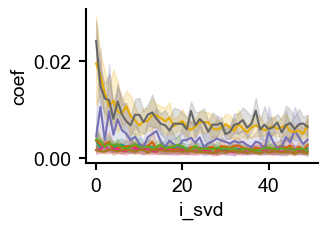

In [196]:
# b/c the mot_svds are not ordered across sessions, plot their decay on average
coef_dfs = {}
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for prot in protocols:
    print(prot)
    
    prot_df = pd.DataFrame(svd_coefs[prot], columns=['name', 'exp_date', 'figure_path'])
    prot_df[np.arange(svd_coefs[prot]['coefs'].shape[1])] = svd_coefs[prot]['coefs']
    sess_avg_prot_df = prot_df.groupby(['name', 'exp_date', 'figure_path'], as_index=False).mean()
    sess_avg_prot_df = sess_avg_prot_df.melt(id_vars=['name', 'exp_date', 'figure_path'], var_name='i_svd', value_name='coef')
    
    plt.figure()
    sns.lineplot(data=sess_avg_prot_df, x='i_svd', y='coef', hue='name', palette=mouse_colors, legend=False)

    columns = ['name', 'exp_date', 'figure_path', 'i_cell', class_name, 'macro_regions', 'cell_types']
    prot_df = pd.DataFrame(prot_coefs[prot], columns=columns)
    prot_df[prot_coefs[prot]['labels'][0]] = prot_coefs[prot]['coefs']
    coef_dfs[prot] = prot_df
hide_spines()

In [197]:
for protocol in protocols:
    print(protocol)
    prot_inds = merge['protocol'] == protocol
    for label in ['expectiles', 'motor', 'history', 'reward']:
        print(label, np.mean(np.logical_and(merge[f'{label}_inds'], prot_inds)))
    print('Median', np.nanmedian(merge.loc[prot_inds, 'full_dev_expl']))
    print('90th %', np.nanpercentile(merge.loc[prot_inds, 'full_dev_expl'], 90))

SameRewDist
expectiles 0.08221892025755324
motor 0.1723625557206538
history 0.04061416542842992
reward 0.07776126795443289
Median 0.00473443591648004
90th % 0.11830910939187074


In [198]:
if table == 'ephys':
    merge.sort_values('total_expectiles_tuning')[['names', 'file_dates', 'neuron_idx_inc', 'means', 'protocol', 'total_expectiles_tuning']].iloc[-50:]

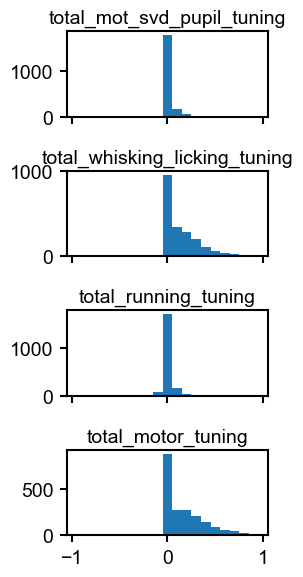

In [199]:
bin_edges = np.linspace(-.95, .95, 20)
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(3,6))
for i_ax, motorvar in enumerate(['total_mot_svd_pupil_tuning', 'total_whisking_licking_tuning', 'total_running_tuning', 'total_motor_tuning']):
    axs[i_ax].hist(merge[motorvar], bin_edges)
    axs[i_ax].set_title(motorvar)
fig.tight_layout()

### Start analysis. Plot frac deviance explained for all neurons, and broken up by striatal subregion or ventral/dorsal (ACB/CP) or genotype, as well as distribution of taus

In [ ]:
# excluding nuissance regressors, therefore a fairer estimate of "meaningful" variability
hist_kwargs = {'kind': 'hist', 'stat': 'probability', 'common_norm': False} 
hist_kwargs = {'col': 'protocol', 'col_order': protocols, **hist_kwargs} if table == 'ephys' else {'col': class_name, 'col_order': class_labels, **hist_kwargs} 

g = sns.displot(data=merge, x='trim_dev_expl', color=[.3]*3, binwidth=.01, height=2.5, aspect=1.3, **hist_kwargs)
g.set(xlim=[-.1, .5])
[plt.savefig('./glm_figs/trim_dev_expl_hist_reg_{}_l1_{}.{}'.format(reg, l1_ratio, ext)) for ext in fmts]

g = sns.displot(data=merge[merge['expectiles_inds']], x='pref_tau', height=2.5, aspect=1.5, **hist_kwargs)
[plt.savefig('./glm_figs/pref_tau_expectiles_inds_hist_reg_{}_l1_{}.{}'.format(reg, l1_ratio, ext)) for ext in fmts]

In [219]:
all_df = pd.DataFrame()
drop_df = pd.DataFrame()

for drop_var in subs:  # looking at the subsets independently
    # looking at the differences and tuning
    data = merge.copy()
    data['drop_var'] = drop_var
    if drop_var == 'all':
        data['diff'] = 0
        data['tuning'] = 0
        all_df = pd.concat((all_df, data))
    else:
        data['diff'] = data[drop_var+'_diff']
        data['tuning'] = data['_'.join(['total', drop_var, 'tuning'])]
        all_df = pd.concat((all_df, data))

        for i, (inds, hist_var, binw, xlim, sub) in enumerate(zip([np.ones(merge.shape[0], dtype=bool), merge[drop_var+'_inds'], merge[drop_var+'_inds']],
                                                   [drop_var+'_diff', drop_var+'_diff', '_'.join(['total', drop_var, 'tuning'])],
                                                   [.001, .002, .1], [(-.02, .07), (0, .3), (-2.5, 2.5)], ['all', drop_var, drop_var])):
    
            inds_data = data[inds]       
                    
            # g = sns.displot(data=data, x=hist_var, binwidth=binw, height=2.5, **hist_kwargs).set_titles("{col_name}")
            # g.set(xlim=xlim)
            # [plt.savefig('./glm_figs/{}_diff_{}_inds_hist_reg_{}_l1_{}.{}'.format(drop_var, sub, reg, l1_ratio, ext)) for ext in fmts]
            
            if hist_var == '_'.join(['total', drop_var, 'tuning']):
                # print(data.shape)
                drop_df = pd.concat((drop_df, inds_data))
                



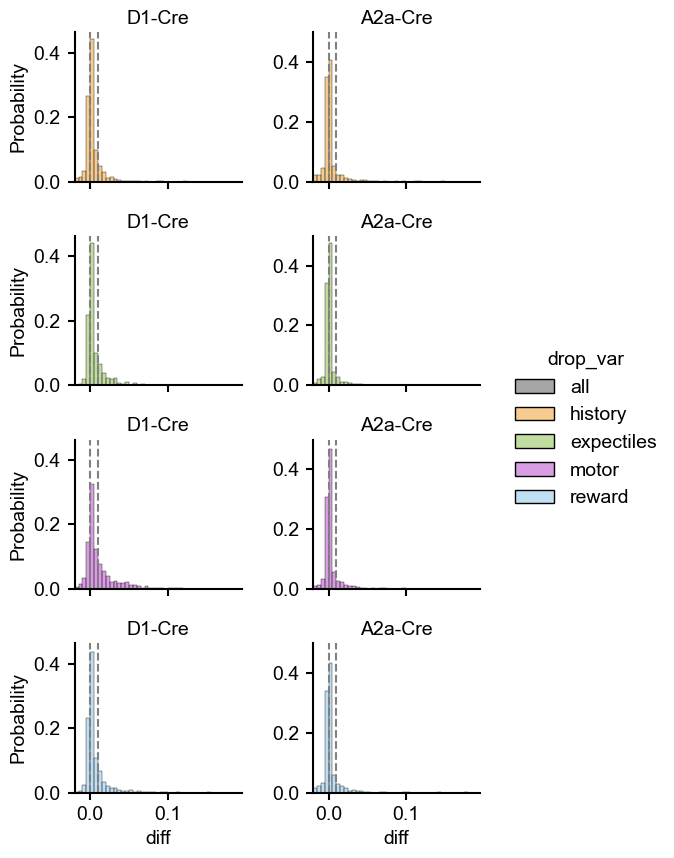

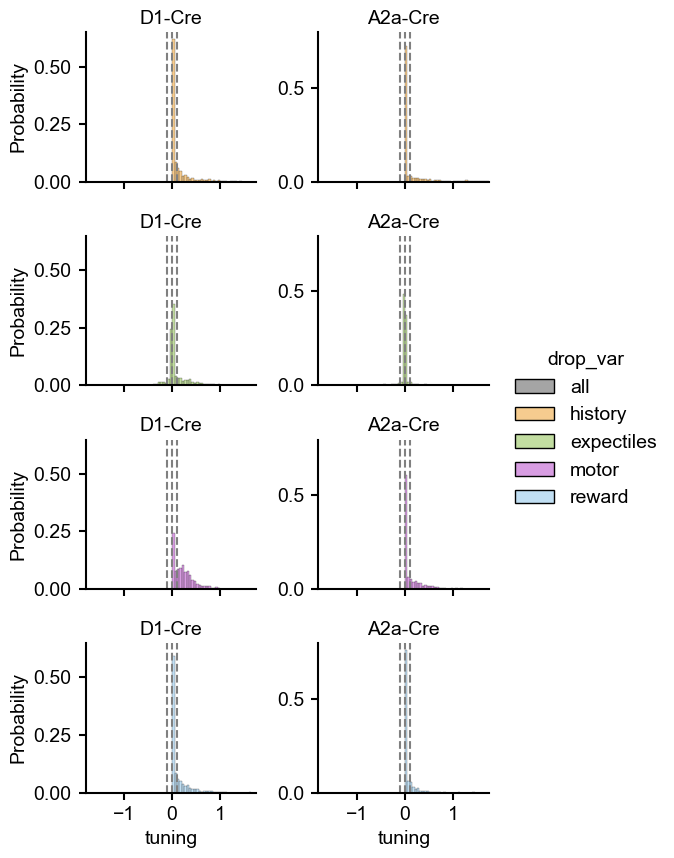

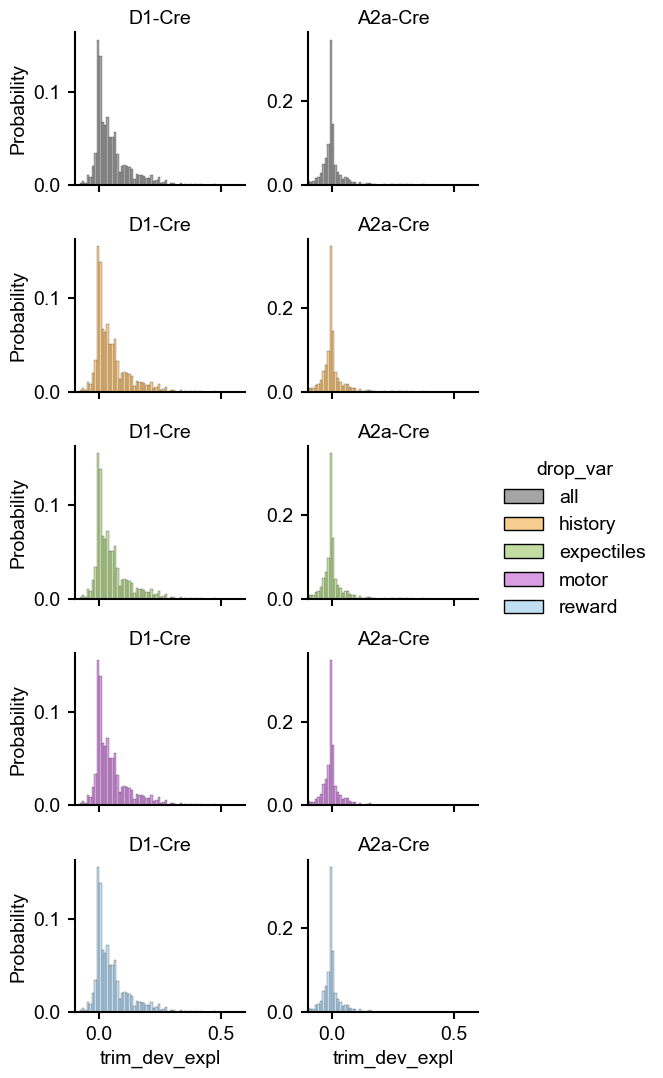

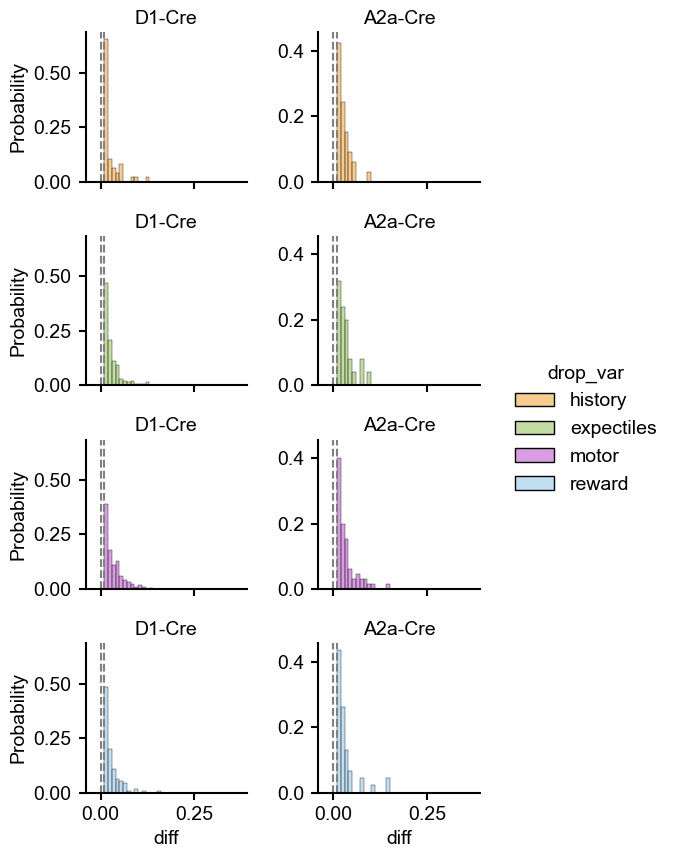

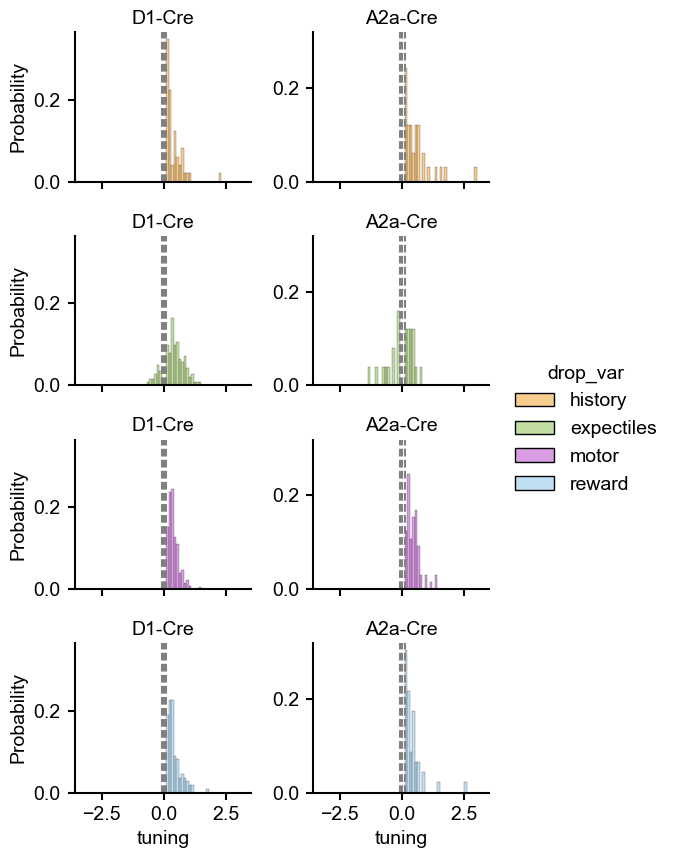

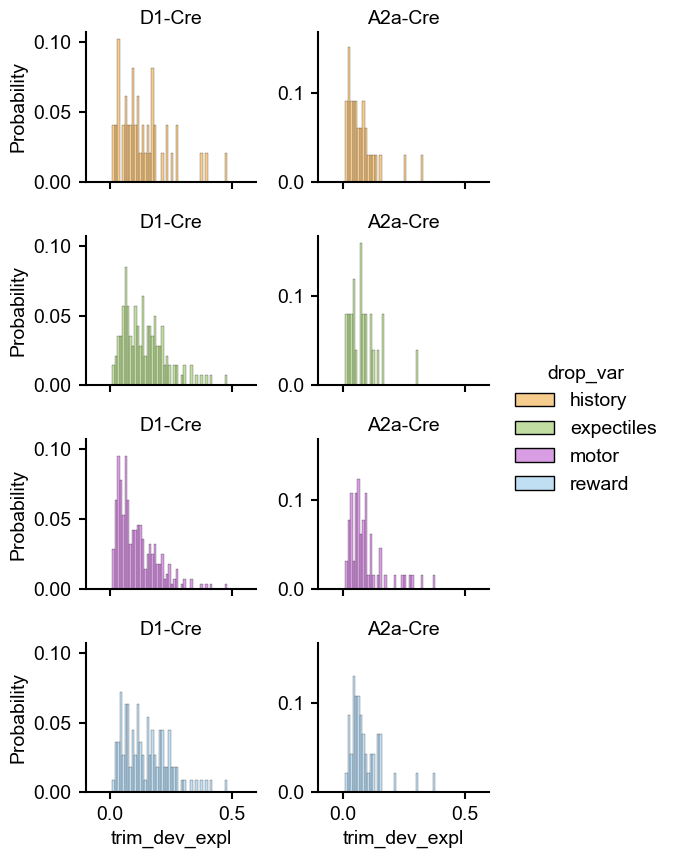

In [220]:
lin = True  # whether to use linear or log scaling
if lin:
    diff_bins = np.arange(-.02, .2, .005)
    tuning_bins = np.arange(-1.8, 1.8, .05)
else:
    diff_bins = np.arange(-.05, .3, .005)
    tuning_bins = np.arange(-3, 3, .05)

trim_dev_bins = np.linspace(-.1, .6, 71)

for df, bins, inds_name, row_orders in zip([all_df.reset_index(), drop_df],
                                     [[diff_bins, tuning_bins, trim_dev_bins], [diff_bins*2, tuning_bins*2, trim_dev_bins]],
                                     # [[(-.05, .3), (-3, 3), (-.1, .6)], [(-.05, .3), (-3, 3), (-.1, .6)]],
                                     ['all', 'subset'], [[drop_vars, drop_vars, subs], [drop_vars, drop_vars, drop_vars]]):
    for value_name, bin, vlines, row_order in zip(['diff', 'tuning', 'trim_dev_expl'], bins, [[0, .01], [-.1, 0, .1], []], row_orders):
        # value_vars = [[f'{drop_var}_diff' for drop_var in drop_vars], ['_'.join(['total', drop_var, 'tuning']) for drop_var in drop_vars]]
        # drop_df_melt = drop_df.melt(id_vars=['names', 'file_dates', 'cluster_id', 'protocol'], value_vars=value_vars, var_name='drop_var', value_name=value_name)
        g = sns.displot(data=df, x=value_name, row='drop_var', hue='drop_var', palette=subs_palette, height=2.2, aspect=1.2, bins=bin,
                        facet_kws={'sharey': 'col'}, row_order=row_order, **hist_kwargs).set_titles("{col_name}")
        g.set(xlim=(bin[0], bin[-1]))
        if not lin: g.set(yscale='log')
        for ax in g.axes.flat:
            for vline in vlines:
                ax.axvline(x=vline, color=[.5]*3, linestyle='--')
        [plt.savefig('./glm_figs/{}_{}_hist_reg_{}_l1_{}_lin_{}.{}'.format(inds_name, value_name, reg, l1_ratio, lin, ext)) for ext in fmts]

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                       Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       total_motor_tuning
No. Observations:         2019          Method:                   REML              
No. Groups:               8             Scale:                    0.0515            
Min. group size:          67            Log-Likelihood:           110.5785          
Max. group size:          554           Converged:                Yes               
Mean group size:          252.4                                                     
------------------------------------------------------------------------------------
                          Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
------------------------------------------------------------------------------------
Intercept               2.075e-01 3.233e-02 6.419e+00 1.367e-10  1.442e-01 2.709e-01
total_expectiles_tuning 4.355e-02 2.645e-02 1.647e+00 9.963e-02 -8.286e-03 9.538e-02
name

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


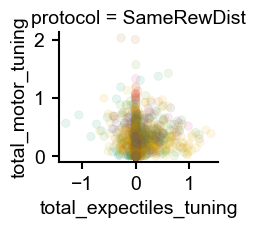

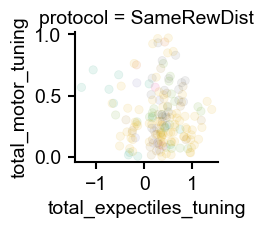

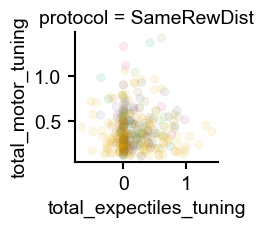

In [203]:
# correlate expectile and motor tuning stregth
for inds, sub in zip([np.ones(merge.shape[0], dtype=bool), merge['expectiles_inds'], merge['motor_inds']], ['all', 'expectiles', 'motor']):
    g = sns.relplot(data=merge[inds], x='total_expectiles_tuning', y='total_motor_tuning', hue='names', col='protocol', legend=False, 
                    height=2.5, edgecolor=None, alpha=.1, palette=mouse_colors)
    [plt.savefig('./glm_figs/expectile_vs_motor_{}_inds_corr_reg_{}_l1_{}.{}'.format(sub, reg, l1_ratio, ext)) for ext in fmts]

    
    model = mixedlm('total_motor_tuning ~ total_expectiles_tuning', merge[inds], groups='names')
    mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
    print(mfit.summary())

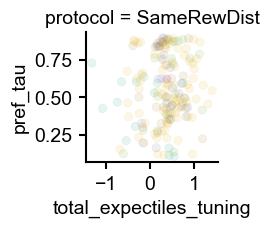

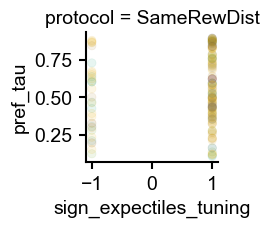

In [204]:
for corrvar in ['total_expectiles_tuning', 'sign_expectiles_tuning']:

    # correlate tuning strength with pref_tau
    g = sns.relplot(data=merge[merge['expectiles_inds']], x=corrvar, y='pref_tau', hue='names', col='protocol', legend=False, 
                    height=2.5, edgecolor=None, alpha=.1, palette=mouse_colors)
    [plt.savefig('./glm_figs/{}_pref_tau_corr_reg_{}_l1_{}.{}'.format(corrvar, reg, l1_ratio, ext)) for ext in fmts]

    for protocol in protocols[:-1]:
        model = mixedlm('pref_tau ~ {}'.format(corrvar), merge[np.logical_and(merge['expectiles_inds'], merge['protocol'] == protocol)],
                        groups='names')
        mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
        print(mfit.summary())

In [205]:
# compute within-session correlations of interest
# - expectiles vs. motor tuning
# - sign/signed magnitude of expectile tuning vs. pref_tau
corr_names = ['oro_vs_run', 'e_vs_tau', 'se_vs_tau'] + [f'{l}_vs_{m}' for (l, m) in drop_tups] + [f'drop{l}_vs_drop{m}' for (l, m) in drop_tups]     
cols = ['names', 'file_dates', 'protocol', 'subtype', 'subs'] + corr_names
sess_df = pd.DataFrame(columns=cols)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for fig_path in np.unique(merge['fig_paths']):
    
        [name, file_date, protocol] = merge.loc[merge['fig_paths'] == fig_path, ['names', 'file_dates', 'protocol']].iloc[0].values

        for sub in subs + class_labels + ['Ventral', 'Dorsal']:
            
            if sub in class_labels:
                inds = merge[class_name] == sub
                subtype = 'cls'
            elif sub in subs:
                subtype = 'func'
                if sub == 'all': inds = np.ones(len(merge), dtype=bool)
                else: inds = merge[f'{sub}_inds']
            else:
                inds = merge['macro_regions'] == sub
                subtype = 'macro'

            # NOTE THE USE OF CUTOFF HERE. Without it, there will be artifactual correlations introduced by the fact that models that
            # are just fitting noise will all tend to have low tuning and deviance differences
            sess = merge[np.logical_and.reduce([merge['fig_paths'] == fig_path, inds, merge['trim_dev_expl'] > cutoff])].reset_index()
            
            if len(sess) > min_size:
                               
                sess_oro_vs_run, _ = stats.pearsonr(sess['total_orofacial_tuning'], sess['total_running_tuning'])
                
                if not np.any(np.isnan(sess['pref_tau'])):
                    sess_e_vs_tau, _ = stats.pearsonr(sess['total_expectiles_tuning'], sess['pref_tau'])
                    sess_se_vs_tau, _ = stats.pearsonr(sess['sign_expectiles_tuning'], sess['pref_tau'])
                else:
                    sess_e_vs_tau, sess_se_vs_tau = np.nan, np.nan

                # stats.pearsonr returns a tuple, 0th entry is the r value
                sess_tcorrs = [stats.pearsonr(sess[f'total_{t1}_tuning'], sess[f'total_{t2}_tuning']) for i, t1 in enumerate(drop_tunings) for t2 in drop_tunings[:i]] 
                sess_dcorrs = [stats.pearsonr(sess[f'{v1}_diff'], sess[f'{v2}_diff']) for i, v1 in enumerate(drop_vars) for v2 in drop_vars[:i]] 
               
            else:
                
                [sess_oro_vs_run, sess_e_vs_tau, sess_se_vs_tau] = [np.nan, np.nan, np.nan]
                sess_tcorrs = [(np.nan, np.nan) for _ in drop_tups]
                sess_dcorrs = [(np.nan, np.nan) for _ in drop_tups]

            sess_df.loc[len(sess_df.index)] = [name, file_date, protocol, subtype, sub, sess_oro_vs_run, sess_e_vs_tau, sess_se_vs_tau] + \
                                              [x[0] for x in sess_tcorrs] + [x[0] for x in sess_dcorrs]

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      oro_vs_run
No. Observations:       21           Method:                  REML      
No. Groups:             4            Scale:                   0.0779    
Min. group size:        2            Log-Likelihood:          -5.2137   
Max. group size:        7            Converged:               Yes       
Mean group size:        5.2                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -2.867e-03 8.358e-02 -3.430e-02 9.726e-01 -1.667e-01 1.609e-01
names Var  1.195e-02 7.881e-02                                          

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      e_vs_tau
No. Observations:       21           Method:                  REML    
No. Groups:             4            Scale:                   0.0547  
Min. group size:        2            Log-Likelihood:          -1.4872 
Max. group size:        7            Converged:               Yes     
Mean group size:        5.2                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.187e-01 6.654e-02 1.783e+00 7.453e-02 -1.175e-02 2.491e-01
names Var 5.940e-03 6.839e-02                                         

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      se_vs_tau
No. Observations:      20           Method:                  REML     
No. Groups:            4            Scale:                   0.0253   
Min. group size:       1            Log-Likelihood:          3.8633   
Max. group size:       7            Converged:               Yes      
Mean group size:       5.0                                            
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 8.364e-02 9.870e-02 8.474e-01 3.968e-01 -1.098e-01 2.771e-01
names Var 3.000e-02 2.179e-01                                         

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       e_vs_h
No. Observations:       21            Method:                   REML  
No. Groups:             4             Scale:                    0.0461
Min. group size:        2             Log-Likelihood:           0.1224
Max. group size:        7             Converged:                Yes   
Mean group size:        5.2                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 5.598e-02 6.367e-02 8.793e-01 3.793e-01 -6.881e-02 1.808e-01
names Var 6.087e-03 6.925e-02                                         

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      m_vs_h 
No. Observations:       21           Method:                  REML   
No. Groups:             4            Scale:                   0.0606 
Min. group size:        2            Log-Likelihood:          -1.8765
Max. group size:        7            Converged:               Yes    
Mean group size:        5.2                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 3.968e-01 5.416e-02 7.326e+00 2.365e-13 2.907e-01 5.030e-01
names Var 6.683e-05 3.857e-02                                        

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      m_vs_e 
No. Observations:        21           Method:                  REML   
No. Groups:              4            Scale:                   0.0722 
Min. group size:         2            Log-Likelihood:          -5.9372
Max. group size:         7            Converged:               Yes    
Mean group size:         5.2                                          
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.086e-01 1.369e-01 1.524e+00 1.275e-01 -5.969e-02 4.769e-01
names Var 5.670e-02 2.592e-01                                         

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      r_vs_h 
No. Observations:       21           Method:                  REML   
No. Groups:             4            Scale:                   0.0621 
Min. group size:        2            Log-Likelihood:          -3.5072
Max. group size:        7            Converged:               Yes    
Mean group size:        5.2                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.919e-01 9.479e-02 3.080e+00 2.072e-03 1.061e-01 4.777e-01
names Var 2.004e-02 1.463e-01                                        

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       r_vs_e
No. Observations:       21            Method:                   REML  
No. Groups:             4             Scale:                    0.0480
Min. group size:        2             Log-Likelihood:           0.4609
Max. group size:        7             Converged:                Yes   
Mean group size:        5.2                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 6.390e-02 4.782e-02 1.336e+00 1.815e-01 -2.983e-02 1.576e-01
names Var 2.583e-11 3.728e-02                                         

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      r_vs_m 
No. Observations:       21           Method:                  REML   
No. Groups:             4            Scale:                   0.0412 
Min. group size:        2            Log-Likelihood:          -0.2405
Max. group size:        7            Converged:               Yes    
Mean group size:        5.2                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.744e-01 9.994e-02 2.745e+00 6.046e-03 7.848e-02 4.703e-01
names Var 2.990e-02 1.807e-01                                        

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    drope_vs_droph
No. Observations:    21         Method:                REML          
No. Groups:          4          Scale:                 0.1982        
Min. group size:     2          Log-Likelihood:        -14.1785      
Max. group size:     7          Converged:             Yes           
Mean group size:     5.2                                             
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 4.353e-01 1.166e-01 3.733e+00 1.895e-04 2.067e-01 6.638e-01
names Var 1.451e-02 9.714e-02                                        

A2a-Cre


/tmp/ipykernel_2853813/4191739520.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:

Across genotype
D1-Cre
                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     dropm_vs_droph
No. Observations:     21          Method:                 REML          
No. Groups:           4           Scale:                  0.0703        
Min. group size:      2           Log-Likelihood:         -3.3444       
Max. group size:      7           Converged:              Yes           
Mean group size:      5.2                                               
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -2.715e-02 5.781e-02 -4.696e-01 6.386e-01 -1.404e-01 8.615e-02
names Var  7.442e-12                                                    

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     dropm_vs_drope
No. Observations:     21          Method:                 REML          
No. Groups:           4           Scale:                  0.0340        
Min. group size:      2           Log-Likelihood:         3.6672        
Max. group size:      7           Converged:              Yes           
Mean group size:      5.2                                               
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -2.649e-02 4.602e-02 -5.756e-01 5.649e-01 -1.167e-01 6.371e-02
names Var  1.213e-03 3.550e-02                                          

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    dropr_vs_droph
No. Observations:    21         Method:                REML          
No. Groups:          4          Scale:                 0.2238        
Min. group size:     2          Log-Likelihood:        -16.3852      
Max. group size:     7          Converged:             Yes           
Mean group size:     5.2                                             
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 4.877e-01 1.780e-01 2.740e+00 6.149e-03 1.388e-01 8.367e-01
names Var 7.693e-02 2.314e-01                                        

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    dropr_vs_drope
No. Observations:    21         Method:                REML          
No. Groups:          4          Scale:                 0.0815        
Min. group size:     2          Log-Likelihood:        -4.8310       
Max. group size:     7          Converged:             Yes           
Mean group size:     5.2                                             
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 5.351e-01 6.432e-02 8.319e+00 8.898e-17 4.090e-01 6.611e-01
names Var 8.228e-12 7.054e-02                                        

A2a-Cre


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

Across genotype
D1-Cre
                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     dropr_vs_dropm
No. Observations:     21          Method:                 REML          
No. Groups:           4           Scale:                  0.0640        
Min. group size:      2           Log-Likelihood:         -2.4114       
Max. group size:      7           Converged:              Yes           
Mean group size:      5.2                                               
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -2.292e-02 5.514e-02 -4.157e-01 6.776e-01 -1.310e-01 8.515e-02
names Var  1.446e-10                                                    

A2a-Cre


<Figure size 300x200 with 0 Axes>

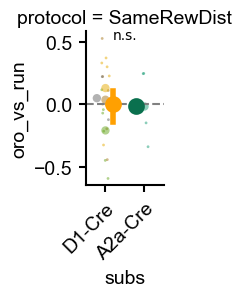

<Figure size 300x200 with 0 Axes>

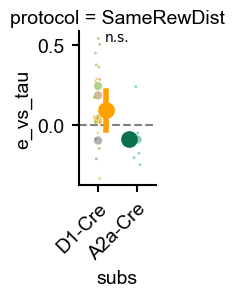

<Figure size 300x200 with 0 Axes>

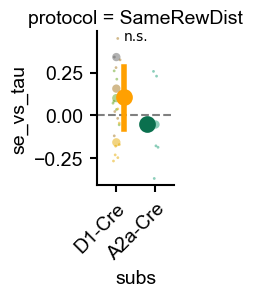

<Figure size 300x200 with 0 Axes>

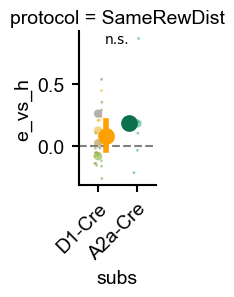

<Figure size 300x200 with 0 Axes>

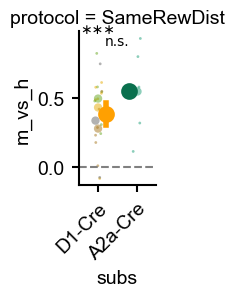

<Figure size 300x200 with 0 Axes>

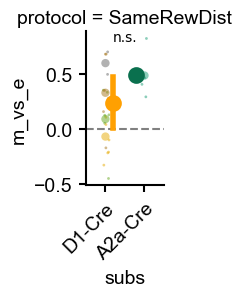

<Figure size 300x200 with 0 Axes>

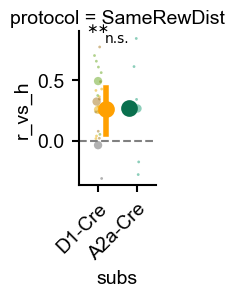

<Figure size 300x200 with 0 Axes>

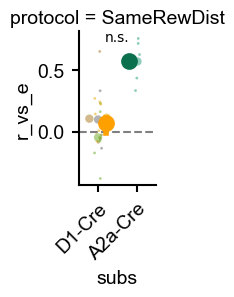

<Figure size 300x200 with 0 Axes>

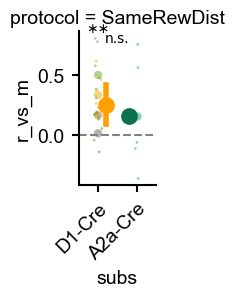

<Figure size 300x200 with 0 Axes>

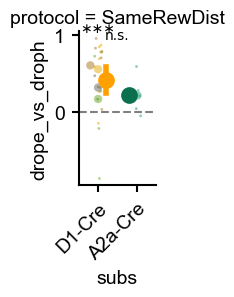

<Figure size 300x200 with 0 Axes>

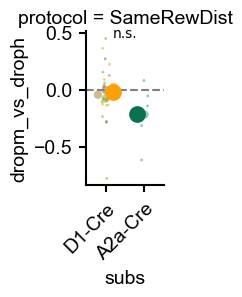

<Figure size 300x200 with 0 Axes>

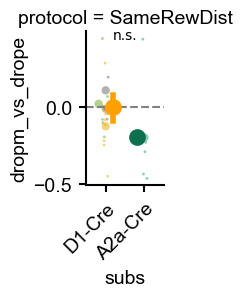

<Figure size 300x200 with 0 Axes>

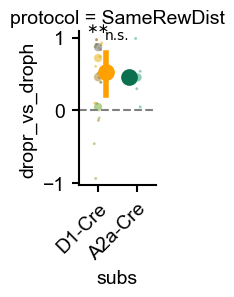

<Figure size 300x200 with 0 Axes>

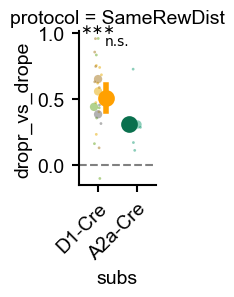

<Figure size 300x200 with 0 Axes>

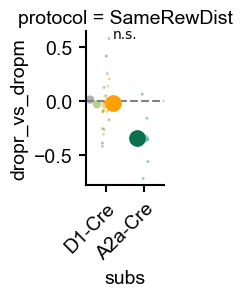

In [207]:
# plot within-session correlations and compute statistics
sess_df_mouse_avg = sess_df.groupby(['names', 'protocol', 'subtype', 'subs'], as_index=False).mean()
for subtype, order, palette in zip(['cls', 'macro', 'func'], [class_labels, ['Ventral', 'Dorsal'], subs],
                                   [cls_palette, macro_palette, subs_palette]):
    
    sub_df = sess_df_mouse_avg[sess_df_mouse_avg['subtype'] == subtype]
    for corrvar in corr_names:
        plt.figure()
        aspect=(len(order) + 3) / 5 if len(order) > 2 else .5
        g = sns.FacetGrid(data=sub_df, col='protocol', col_order=protocols, height=2, aspect=aspect, sharey=False, 
                          gridspec_kws={'wspace': 0.3, 'hspace': 0.5})
        g.map_dataframe(sns.swarmplot, x='subs', y=corrvar, hue='names', order=order, alpha=.5, legend=False, zorder=1, size=6, palette=mouse_colors)
        # g = sns.catplot(data=sub_df, col='protocol', col_order=protocols, height=2, aspect=(len(order) + 3) / 5, x='subs', y=corrvar, 
        #                 hue='names', order=order, alpha=.5, kind='swarm', legend=False, zorder=1, size=6, palette=mouse_colors)
        [sns.stripplot(data=sess_df[np.logical_and(sess_df['protocol'] == prot, sess_df['subtype'] == subtype)], x='subs', y=corrvar, hue='names', order=order, size=2, alpha=.5, 
                       legend=False, zorder=0, ax=ax, palette=mouse_colors) for ax, prot in zip(g.axes.flat, protocols)]
        g.map_dataframe(sns.pointplot, x='subs', y=corrvar, hue='subs', markersize=10, dodge=0.4, order=order, palette=palette, zorder=5,
                        err_kws={'linewidth': 4}, errorbar=('ci', 95))
        g.refline(y=0)
        [ax.set_xticks(np.arange(len(order))) for ax in g.axes.flat]
        [ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor') for ax in g.axes[0]]
        
        # MLE stats
        # for i_sub, sub in enumerate(col_order):
        for i_prot, prot in enumerate(protocols):
            
            # for protocol in protocols:
            if len(order) == 2:
                print('Across {}'.format(class_name))
                if len(np.unique(use_df['names'])) > 1 and len(use_df) > 2:
                    model = mixedlm('{} ~ C(subs)'.format(corrvar),
                                    sess_df.loc[np.logical_and(sess_df['protocol'] == prot, sess_df['subtype'] == subtype)].dropna(), groups='names')
                    mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
                    print(mfit.summary())
                    pvals = mfit.summary().tables[1][-len(order):-1]['P>|z|'].values
                    pvals = np.array([np.float64(x) if x != '' else 1. for x in pvals])
                else: pvals = [1]
                plot_stars(g.axes.flat[i_prot], [0.5], pvals, ytop_scale=0.9, show_ns=True)

            pvals = []
            for sub in order:
                print(sub)
                use_df = sess_df.loc[np.logical_and.reduce([sess_df['protocol'] == prot, sess_df['subs'] == sub, 
                                                            sess_df['subtype'] == subtype]), ['names', corrvar]].dropna()
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    if len(np.unique(use_df['names'])) > 1 and len(use_df) > 2:
                        model = mixedlm('{} ~ 1'.format(corrvar), use_df, groups='names')
                        mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
                        if i_prot == 0:
                            print(mfit.summary())
                        tmp = mfit.summary().tables[1]['P>|z|'][0]
                        pvals.append(1 if tmp == '' else float(tmp))
                    else: pvals.append(1)
            plot_stars(g.axes.flat[i_prot], np.arange(len(order)), pvals)
        [plt.savefig('./glm_figs/{}_across_{}_{}_corr_reg_{}_l1_{}.{}'.format(corrvar, subtype, manipulation, reg, l1_ratio, ext)) for ext in fmts]
    break

In [208]:
median_cols = [col for col in merge.columns if 'dev' in col or 'diff' in col]
agg_dict = {col: 'median' for col in median_cols}

mean_cols = [col for col in merge.columns if 'inds' in col or 'tau' in col or 'tuning' in col]
mean_dict = {col: 'mean' for col in mean_cols}

agg_dict.update(mean_dict)

# data limited to str_regions
incl_df = merge[np.isin(merge[class_name], class_labels)]

In [214]:
# aggregate the data, either all neurons or only history/expectiles/motor inds
incl = {}
ind_size = 10
# for ephys, treat each session independently, but for imaging, ignore session and just average over neurons
sess_level = [] if table == 'imaging' else ['file_dates']

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for subset, subset_name in zip([incl_df['trim_dev_expl'] > cutoff, np.ones(len(incl_df), dtype=bool), incl_df['history_inds'],
                                    incl_df['expectiles_inds'], incl_df['motor_inds'], incl_df['reward_inds']],
                                   ['good', 'all', 'history', 'expectiles', 'motor', 'reward']):

        # restrict statistics to sessions with at least ind_size of the relevant neurons (because we're computing fraction of inds)
        incl_date_subr = incl_df[subset].groupby(['names', class_name, 'protocol', *sess_level]).filter(
            lambda x: len(x) >= ind_size).groupby(['names', class_name, 'protocol', *sess_level], as_index=False).agg(agg_dict)  # .dropna()
        incl_subr_sess = incl_date_subr.groupby(['names', class_name, 'protocol'], as_index=False).mean()  # mean across sessions
        
        incl_date = incl_df[subset].groupby(['names', 'protocol', *sess_level]).filter(
            lambda x: len(x) >= ind_size).groupby(['names', 'protocol', *sess_level], as_index=False).agg(agg_dict)  # .dropna()
        incl_sess = incl_date.groupby(['names', 'protocol'], as_index=False).mean()
    
        incl_macro_sess = incl_df[subset].copy()
        # incl_macro_sess['macro_regions'] = 'Ventral'
        # incl_macro_sess.loc[np.isin(incl_macro_sess['str_regions'], ['VMS', 'VLS', 'DMS', 'DLS']), 'macro_regions'] = 'Dorsal'
        incl_macro_sess[class_name] = incl_macro_sess['macro_regions']
        incl_macro_sess = incl_macro_sess.groupby(['names', class_name, 'protocol', *sess_level]).filter(
            lambda x: len(x) >= ind_size).groupby(['names', class_name, 'protocol', *sess_level], as_index=False).agg(agg_dict)  # .dropna()
        # incl_macro_sess = incl_macro_sess.groupby(['names', class_name, 'protocol'], as_index=False).mean()
    
        incl[subset_name] = {'neuron': incl_df[subset], 'date_subr': incl_date_subr, 'subr_sess': incl_subr_sess, 'date': incl_date, 'sess': incl_sess, 'macro_sess': incl_macro_sess}

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        trim_dev_expl
No. Observations:          2019           Method:                    REML         
No. Groups:                8              Scale:                     0.0051       
Min. group size:           67             Log-Likelihood:            2387.2816    
Max. group size:           554            Converged:                 Yes          
Mean group size:           252.4                                                  
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             1.580e-03 6.781e-03 2.330e-01 8.158e-01 -1.171e-02 1.487e-02
C(genotype)[T.D1-Cre] 4.087e-02 1.027e-02 3.980e+00 6.900e-05  2.074e-02 6.099e-02
file_dates Var        1.403

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         history_diff
No. Observations:         2019            Method:                     REML        
No. Groups:               8               Scale:                      0.0004      
Min. group size:          67              Log-Likelihood:             5108.0836   
Max. group size:          554             Converged:                  Yes         
Mean group size:          252.4                                                   
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             4.632e-04 7.328e-04 6.320e-01 5.274e-01 -9.731e-04 1.899e-03
C(genotype)[T.D1-Cre] 2.644e-03 1.077e-03 2.454e+00 1.414e-02  5.319e-04 4.755e-03
file_dates Var        5.500

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        expectiles_diff
No. Observations:        2019           Method:                    REML           
No. Groups:              8              Scale:                     0.0011         
Min. group size:         67             Log-Likelihood:            4006.3955      
Max. group size:         554            Converged:                 Yes            
Mean group size:         252.4                                                    
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             1.556e-03 1.669e-03 9.322e-01 3.512e-01 -1.715e-03 4.827e-03
C(genotype)[T.D1-Cre] 8.266e-03 2.490e-03 3.319e+00 9.026e-04  3.385e-03 1.315e-02
file_dates Var        5.615

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         motor_diff
No. Observations:           2019            Method:                     REML      
No. Groups:                 8               Scale:                      0.0019    
Min. group size:            67              Log-Likelihood:             3377.8004 
Max. group size:            554             Converged:                  Yes       
Mean group size:            252.4                                                 
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             2.796e-03 5.584e-03 5.008e-01 6.165e-01 -8.148e-03 1.374e-02
C(genotype)[T.D1-Cre] 1.201e-03 8.486e-03 1.415e-01 8.875e-01 -1.543e-02 1.783e-02
file_dates Var        1.026

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         reward_diff
No. Observations:         2019            Method:                     REML       
No. Groups:               8               Scale:                      0.0003     
Min. group size:          67              Log-Likelihood:             5169.2020  
Max. group size:          554             Converged:                  Yes        
Mean group size:          252.4                                                  
---------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------------------
Intercept             2.147e-03 7.217e-04 2.975e+00 2.929e-03 7.326e-04 3.562e-03
C(genotype)[T.D1-Cre] 4.108e-03 1.065e-03 3.858e+00 1.143e-04 2.021e-03 6.195e-03
file_dates Var        5.914e-06 1.603e

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                       Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       total_history_tuning
No. Observations:       2019          Method:                   REML                
No. Groups:             8             Scale:                    0.1483              
Min. group size:        67            Log-Likelihood:           -970.2550           
Max. group size:        554           Converged:                Yes                 
Mean group size:        252.4                                                       
------------------------------------------------------------------------------------
                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------------------
Intercept              1.859e-01 1.909e-02  9.735e+00 2.133e-22  1.485e-01 2.233e-01
C(genotype)[T.D1-Cre] -5.400e-02 2.828e-02 -1.910e+00 5.619e-02 -1.094e-01 1.424e-03
file

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   total_abs_expectiles_tuning
No. Observations:     2019      Method:               REML                       
No. Groups:           8         Scale:                0.0277                     
Min. group size:      67        Log-Likelihood:       699.7879                   
Max. group size:      554       Converged:            Yes                        
Mean group size:      252.4                                                      
---------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------------------
Intercept             3.794e-02 1.207e-02 3.143e+00 1.674e-03 1.428e-02 6.160e-02
C(genotype)[T.D1-Cre] 1.059e-01 1.820e-02 5.819e+00 5.935e-09 7.021e-02 1.415e-01
file_dates Var        3.973e-03 5.532e

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      total_motor_tuning
No. Observations:        2019         Method:                  REML              
No. Groups:              8            Scale:                   0.0498            
Min. group size:         67           Log-Likelihood:          117.4692          
Max. group size:         554          Converged:               Yes               
Mean group size:         252.4                                                   
---------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------------------
Intercept             1.335e-01 1.353e-02 9.868e+00 5.752e-23 1.070e-01 1.601e-01
C(genotype)[T.D1-Cre] 1.209e-01 2.034e-02 5.945e+00 2.761e-09 8.107e-02 1.608e-01
file_dates Var        4.410e-03 5.764e

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      total_reward_tuning
No. Observations:       2019         Method:                  REML               
No. Groups:             8            Scale:                   0.0320             
Min. group size:        67           Log-Likelihood:          575.5454           
Max. group size:        554          Converged:               Yes                
Mean group size:        252.4                                                    
---------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------------------
Intercept             6.029e-02 8.970e-03 6.721e+00 1.810e-11 4.270e-02 7.787e-02
C(genotype)[T.D1-Cre] 5.796e-02 1.339e-02 4.327e+00 1.510e-05 3.171e-02 8.421e-02
file_dates Var        1.581e-03 2.607e

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         history_inds
No. Observations:         8               Method:                     REML        
No. Groups:               8               Scale:                      0.0005      
Min. group size:          1               Log-Likelihood:             11.6720     
Max. group size:          1               Converged:                  Yes         
Mean group size:          1.0                                                     
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             3.851e-02 1.373e-02 2.806e+00 5.018e-03  1.161e-02 6.542e-02
C(genotype)[T.D1-Cre] 8.791e-03 1.941e-02 4.529e-01 6.506e-01 -2.925e-02 4.684e-02
names Var             2.218

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        expectiles_inds
No. Observations:        8              Method:                    REML           
No. Groups:              8              Scale:                     0.0014         
Min. group size:         1              Log-Likelihood:            4.9901         
Max. group size:         1              Converged:                 Yes            
Mean group size:         1.0                                                      
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             3.445e-02 4.180e-02 8.242e-01 4.098e-01 -4.748e-02 1.164e-01
C(genotype)[T.D1-Cre] 1.344e-01 5.912e-02 2.273e+00 2.300e-02  1.853e-02 2.503e-01
names Var             5.627

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         motor_inds
No. Observations:           8               Method:                     REML      
No. Groups:                 8               Scale:                      0.0068    
Min. group size:            1               Log-Likelihood:             0.5974    
Max. group size:            1               Converged:                  Yes       
Mean group size:            1.0                                                   
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             8.299e-02 8.693e-02 9.547e-01 3.397e-01 -8.739e-02 2.534e-01
C(genotype)[T.D1-Cre] 2.579e-01 1.229e-01 2.098e+00 3.591e-02  1.696e-02 4.988e-01
names Var             2.341

/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         reward_inds
No. Observations:          8               Method:                     REML       
No. Groups:                8               Scale:                      0.0010     
Min. group size:           1               Log-Likelihood:             6.0200     
Max. group size:           1               Converged:                  Yes        
Mean group size:           1.0                                                    
----------------------------------------------------------------------------------
                        Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------
Intercept             5.540e-02 3.521e-02 1.573e+00 1.156e-01 -1.361e-02 1.244e-01
C(genotype)[T.D1-Cre] 4.750e-02 4.979e-02 9.539e-01 3.401e-01 -5.009e-02 1.451e-01
names Var             3.967

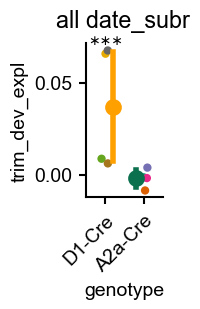

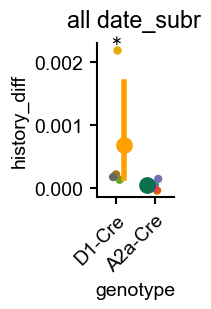

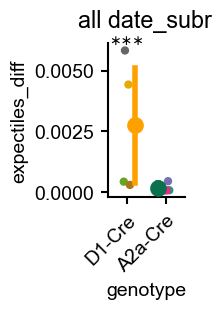

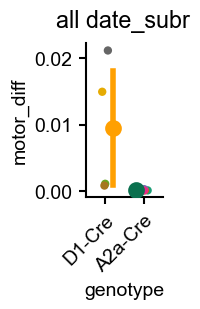

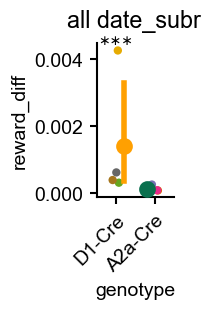

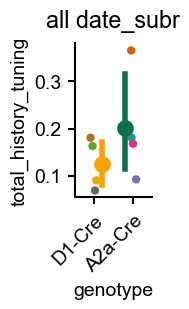

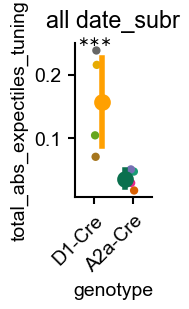

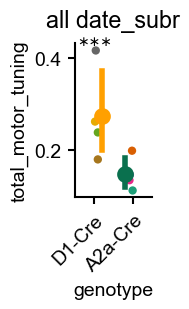

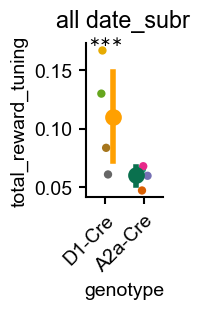

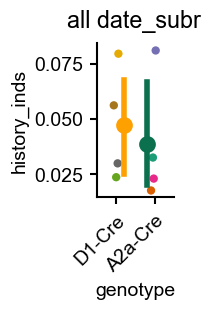

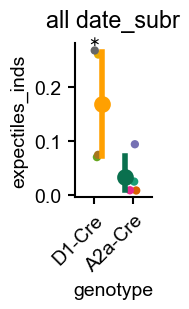

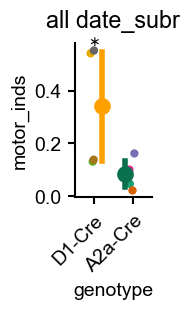

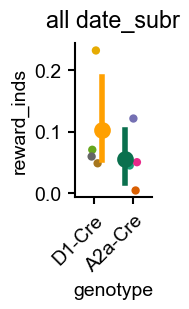

In [217]:
fmts = ['png', 'pdf']
var_inds = ['history_inds', 'expectiles_inds', 'motor_inds', 'reward_inds']

grid_kwargs = dict(col='protocol', col_order=protocols, height=2, sharey=False, gridspec_kws={'wspace': 0.3, 'hspace': 0.5})
hue_kwargs = dict(x=class_name, hue='names', palette=mouse_colors, zorder=1, legend=False)
mean_kwargs = dict(x=class_name, hue=class_name, err_kws={'linewidth': 4}, errorbar=('ci', 95), zorder=10)

for subset_name, extras in zip(['all', 'good', 'expectiles', 'history', 'motor', 'reward'], 
                               [var_inds, var_inds, ['pref_tau'], [], [], []]):
# for subset_name, extra in zip(['all', 'history', 'expectiles', 'motor'], ['expectiles_inds', 'total_history_tuning', 'pref_tau', 'frac_orofacial_tuning']):
# for subset_name, extra in zip(['all'], ['expectiles_inds']):
    for reg_spec, palette, order in zip(['date_subr', 'macro_sess'], [cls_palette, macro_palette], [class_labels, ['Ventral', 'Dorsal']]):

        neuron_data = incl[subset_name]['neuron']
        sess_data = incl[subset_name][reg_spec]
       
        for depvar in ['trim_dev_expl', 'history_diff', 'expectiles_diff', 'motor_diff', 'reward_diff', 'total_history_tuning',
                       'total_abs_expectiles_tuning', 'total_motor_tuning', 'total_reward_tuning', *extras]:

            if depvar in extras:
                data = sess_data.groupby(['names', class_name, 'protocol'], as_index=False).mean()
            else:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    data = neuron_data.groupby(['names', class_name, 'protocol'], as_index=False).agg(agg_dict)

            aspect=((len(order) + 3) / 5) if len(order) > 2 else .5
            g = sns.FacetGrid(data=data, aspect=aspect, **grid_kwargs)
            if order == class_labels:
                [ax.set_xticks(np.arange(len(order))) for ax in g.axes.flat]
                [ax.set_xticklabels(class_labels, rotation=45, ha='right', rotation_mode='anchor') for ax in g.axes.flat]
            figtitle = "{} {}".format(subset_name, reg_spec)
            g.fig.suptitle(figtitle, y=1.05)
            
            try:
                g.map_dataframe(sns.stripplot, y=depvar, order=order, size=6, **hue_kwargs)
                g.map_dataframe(sns.pointplot, y=depvar, order=order, palette=palette, markersize=10, dodge=0.4, **mean_kwargs).set_titles("")                    
                # g = sns.catplot(data=data, x=class_name, y=depvar, hue='names', col='protocol', order=order, kind='strip', size=4,
                #                 legend=False, col_order=protocols, height=3, palette=mouse_colors)  # markers=None, linewidth=1,
                # g.map_dataframe(sns.pointplot, x=class_name, y=depvar, hue=class_name, order=order, legend=False, linestyles='',
                #                 linewidth=3, palette=palette)
                
            except ZeroDivisionError:
                pass         

            # MLE stats
            # for i_sub, sub in enumerate(col_order):
            for i_prot, prot in enumerate(protocols):
                if depvar in extras:  # session level
                    use_df = sess_data.loc[sess_data['protocol'] == prot, ['names', class_name, depvar]].dropna()
                    vc_formula = None
                else:
                    use_df = neuron_data.loc[neuron_data['protocol'] == prot, ['names', class_name, depvar, 'file_dates']].dropna()
                    vc_formula = {'file_dates': '0 + C(file_dates)'}
                    # print(neuron_data[neuron_data['protocol'] == prot])
                    # print(use_df)
                with warnings.catch_warnings():
                    try:
                        warnings.simplefilter('ignore')
                        model = mixedlm('{} ~ C({})'.format(depvar, class_name), use_df, vc_formula=vc_formula, groups='names')
                        mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
                        print(mfit.summary())
                    except LinAlgError:
                        continue
                    regions = mfit.summary().tables[1][-len(order):-1].index
                    reg_ind = [np.flatnonzero([regstr in reg for reg in regions]) for regstr in order]
                    reg_ind_flat = np.array([x[0] for x in reg_ind if x.size > 0])
                    centers = np.flatnonzero([x.size > 0 for x in reg_ind])
                    if reg_ind_flat.size > 0:
                        pvals = mfit.summary().tables[1][-len(order):-1]['P>|z|'].values
                        pvals = np.array([np.float64(x) if x != '' else 1. for x in pvals])
                        plot_stars(g.axes.flat[i_prot], centers, pvals[reg_ind_flat])
                
                    # pvals = []
                    # # for protocol in protocols:
                    # for sub in order:
                    #     use_df = sess_data.loc[np.logical_and(sess_data['protocol'] == prot, sess_data['str_regions'] == sub), ['names', depvar]].dropna()
                    #     if len(use_df) > 1:
                    #         model = mixedlm('{} ~ 1'.format(depvar), use_df, groups='names')
                    #         mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
                    #         print(mfit.summary())
                    #         tmp = mfit.summary().tables[1]['P>|z|'][0]
                    #         pvals.append(1 if tmp == '' else float(tmp))
                    #     else: pvals.append(1)
                    # plot_stars(g.axes.flat[i_prot], np.arange(len(order)), pvals, ytop_scale=1.1)
            
            [plt.savefig('./glm_figs/{}_{}_{}_reg_{}_l1_{}.{}'.format(figtitle, depvar, manipulation, reg, l1_ratio, fmt)) for fmt in fmts]
        break  # stop after subregion breakdown, don't bother doing macro
    break  # stop after all subset
            

# Compare encoding and decoding definitions of distribution/expectile coding subpopulations

In [211]:
from matplotlib_venn import venn3, venn2

In [212]:
with open('_'.join(['SameRewDist', 'combined', 'spks', 'data', '20230918.p']), 'rb') as f:
    d = pickle.load(f)

In [213]:
cutoffs = [73, 97]
dn = pd.DataFrame(d['neuron_info']).merge(merge, on=['names', 'file_dates', 'cluster_id', 'neuron_idx_good', 'neuron_idx_inc'])
dn['uid'] = dn[['names', 'file_dates', 'neuron_idx_inc']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

KeyError: 'cluster_id'

73
0.11431020933057083 0.11666785739801386 0.0168607558762592 0.013336327201316152
0.11431020933057083 0.4167321568907623 0.04693862970636565 0.04763674008896333
97
0.02257626634278774 0.11666785739801386 0.005572622704865329 0.00263392462225994
0.02257626634278774 0.4167321568907623 0.010216474958919768 0.009408256167570257


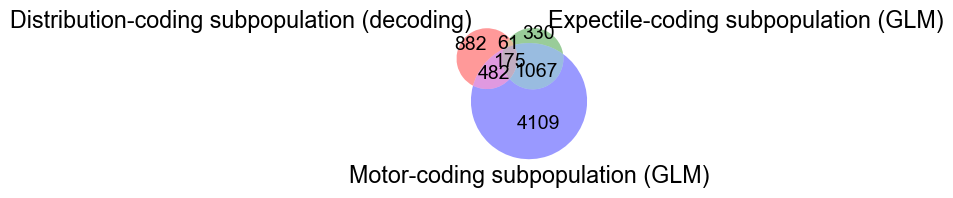

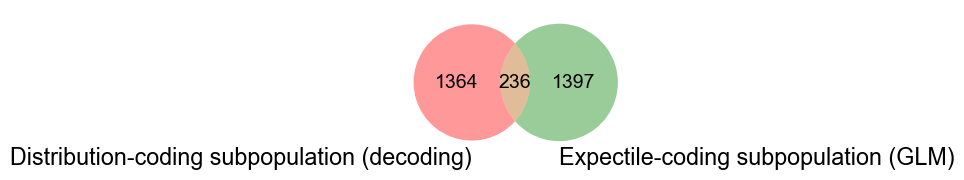

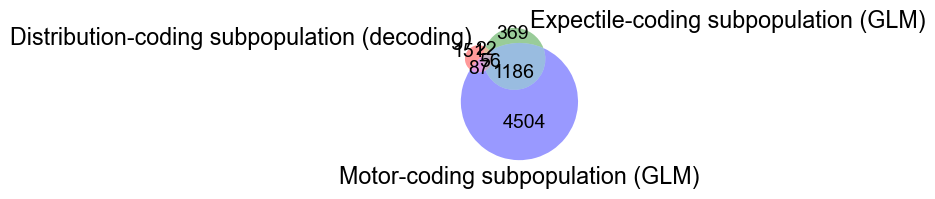

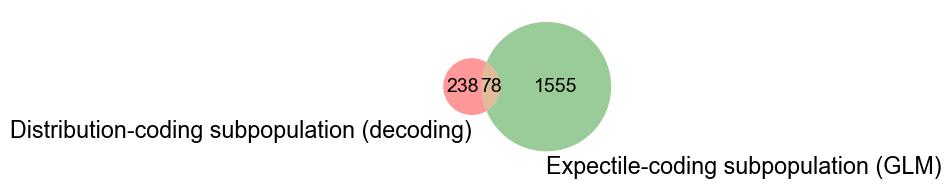

In [96]:
for cutoff in cutoffs:
    print(cutoff)
    cut_key = f'cutoff_{cutoff}'
    print(dn[cut_key].mean(), dn['expectiles_inds'].mean(), np.logical_and(dn[cut_key], dn['expectiles_inds']).mean(),
     dn[cut_key].mean() * dn['expectiles_inds'].mean())
    print(dn[cut_key].mean(), dn['motor_inds'].mean(), np.logical_and(dn[cut_key], dn['motor_inds']).mean(),
         dn[cut_key].mean() * dn['motor_inds'].mean())

    # the functions venn3 and venn3_circles take a 7-element list of subset sizes (Abc, aBc, ABc, abC, AbC, aBC, ABC)
    # and draw a three-circle area-weighted venn diagram. Alternatively, you can provide a list of three set or Counter 
    # objects (rather than counting sizes for all 7 subsets).
    plt.figure()
    venn3([set(dn.loc[dn[cut_key], 'uid']), set(dn.loc[dn['expectiles_inds'], 'uid']), set(dn.loc[dn['motor_inds'], 'uid'])],
          set_labels=['Distribution-coding subpopulation (decoding)', 'Expectile-coding subpopulation (GLM)', 'Motor-coding subpopulation (GLM)']) 
    plt.figure()
    venn2([set(dn.loc[dn[cut_key], 'uid']), set(dn.loc[dn['expectiles_inds'], 'uid'])],
          set_labels=['Distribution-coding subpopulation (decoding)', 'Expectile-coding subpopulation (GLM)']) 

# Perform unsupervised clustering on the full model coefficients

In [82]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

def gmm_aic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.aic(X)

In [83]:
gmm_df = pd.DataFrame(columns=['Number of PCs', 'Number of clusters', 'Type of covariance', 'BIC score', 'AIC score',
                               'protocol', 'param_reg_covar'])

for protocol, prot_df in coef_dfs.items():
    
    print(protocol)
# if True:
#     protocol = 'SameRewDist'
#     pdict = prot_coefs['SameRewDist']
    for n_comps in np.arange(2, 5):
    # for n_comps in np.arange(5, 7):
        print(n_comps)
    # for n_comps in [np.shape(pdict['coefs'])[1]]:
        
        # reduce dimensionality along the regressors
        pca = PCA(n_components=n_comps)
        # important! z-score the coefficients across regressors before pca!
        zcoefs = stats.zscore(np.array(prot_df[prot_coefs[protocol]['labels'][0]]), axis=1)
        reduced_coefs = pca.fit_transform(zcoefs)
        # reduced_coefs = pdict['coefs']

        # cluster with GMM, searching over n_clusters and covariance_type
        param_grid = {
            "n_components": range(1, 11),
            "covariance_type": ["full"],  #  ['spherical'],  #
            "max_iter": [200],
            "reg_covar": [1e-6, 1e-2, .4]
        }
        grid_search = GridSearchCV(GaussianMixture(), param_grid=param_grid, scoring={'bic': gmm_bic_score, 'aic': gmm_aic_score}, refit='bic')
        grid_search.fit(reduced_coefs)

        # create a df to contain the results of grid search
        df = pd.DataFrame(grid_search.cv_results_)[
            ["param_n_components", "param_covariance_type", "mean_test_bic", "mean_test_aic", "param_reg_covar"]
        ]
        # re-inverse the sign of the BIC score to show the effect of minimizing it
        df["mean_test_bic"] = -df["mean_test_bic"]
        df['mean_test_aic'] = -df["mean_test_aic"]
        df = df.rename(
            columns={
                "param_n_components": "Number of clusters",
                "param_covariance_type": "Type of covariance",
                "mean_test_bic": "BIC score",
                "mean_test_aic": "AIC score",
            }
        )
        # concatenate this run (n_pcs, protocol) with all of gmm_df for later plotting
        df['Number of PCs'] = n_comps
        df['protocol'] = protocol
        # print(df.shape)
        gmm_df = pd.concat((gmm_df, df))

SameRewDist
2
3
4
Bernoulli
2
3
4
DistributionalRL_6Odours
2
3
4


[None]

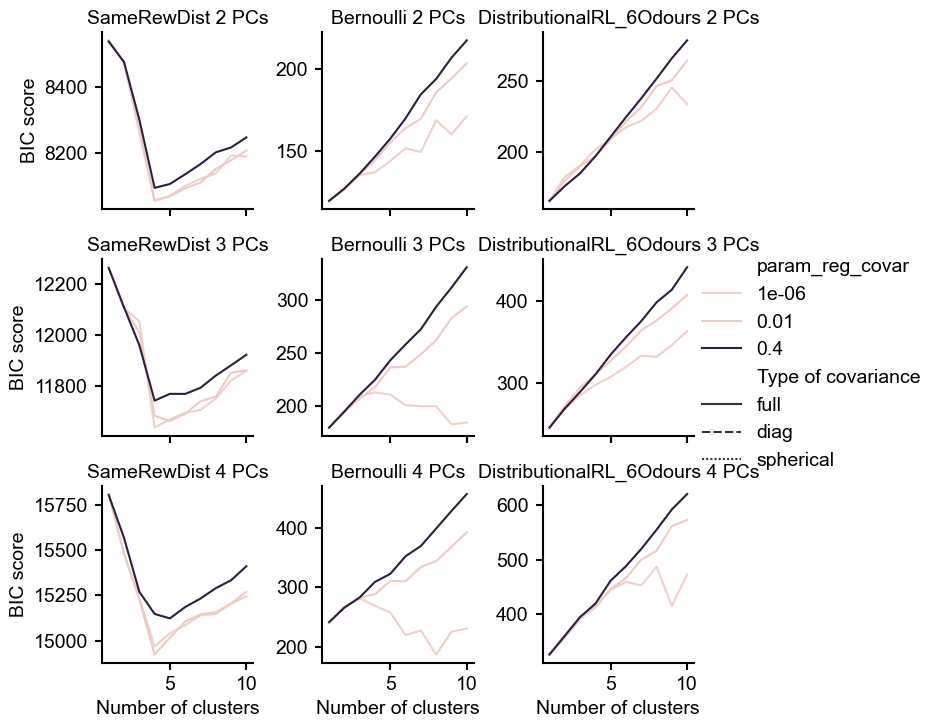

In [84]:
rowname = 'Number of PCs'
colname = 'protocol'
sns.relplot(data=gmm_df, col=colname, row=rowname, style='Type of covariance', x='Number of clusters', y='BIC score', hue='param_reg_covar',
            kind='line', height=2.5, facet_kws={'sharey': False}, style_order=['full', 'diag', 'spherical']).set_titles("{col_name} {row_name} PCs")
[plt.savefig('./glm_figs/gmm_df_row_{}_col_{}_reg_{}_l1_{}.{}'.format(rowname, colname, reg, l1_ratio, fmt)) for fmt in fmts]

In [85]:
for prot in protocols:
    prot_df = gmm_df[np.logical_and.reduce([gmm_df['protocol'] == prot, gmm_df['Number of PCs'] == 4, gmm_df['param_reg_covar'] == 0.4])]  # 
    print(prot_df.iloc[np.argsort(prot_df['BIC score'])[:10]])

   Number of PCs Number of clusters Type of covariance     BIC score  \
14             4                  5               full  15123.107516   
11             4                  4               full  15147.911708   
17             4                  6               full  15186.134092   
20             4                  7               full  15232.725038   
8              4                  3               full  15270.753582   
23             4                  8               full  15290.322869   
26             4                  9               full  15334.097681   
29             4                 10               full  15411.446332   
5              4                  2               full  15568.655118   
2              4                  1               full  15805.323932   

       AIC score     protocol param_reg_covar  
14  14777.790397  SameRewDist             0.4  
11  14872.591302  SameRewDist             0.4  
17  14770.820259  SameRewDist             0.4  
20  14747.41449

# For the time being, let's just go with 3 PCs and dynamically select the number of clusters

SameRewDist
Bernoulli
DistributionalRL_6Odours


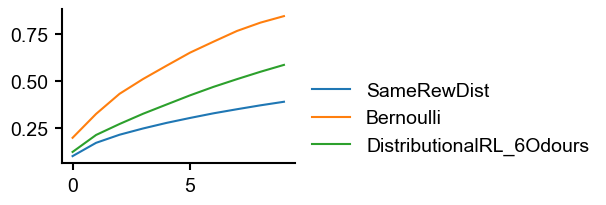

In [86]:
# scree plot
n_comps = 10
for protocol, prot_df in coef_dfs.items():
    print(protocol)
    pca = PCA(n_components=n_comps)
    # important! z-score the coefficients across regressors before pca!
    zcoefs = stats.zscore(np.array(prot_df[prot_coefs[protocol]['labels'][0]]), axis=1)
    pca.fit(zcoefs)
    plt.plot(np.arange(n_comps), np.cumsum(pca.explained_variance_ratio_))
plt.legend(protocols, loc=(1.04, 0))
hide_spines()

In [87]:
sensory = ['{:.1f}-expectile'.format(tau) for tau in taus] + tt_names

# Get group names for all convolved features
group_name_conv = [
    'Reward present',
    'Reward magnitude',
    'RPE'
 ] + sensory + [
    'Licking',
    'whisking',
    'running',
]

# important! ensure that the relative ordering (licking, then whisking, then running) is the same here as for conv
group_name_pred = [
    'Licking_pred',
     'whisking_pred',
     'running_pred'
]

SameRewDist 4
(154, 3928, 17)
(154, 3928, 3)


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.tru

Bernoulli 1
(154, 46, 15)
(154, 46, 3)


/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.tru

DistributionalRL_6Odours 1
(154, 68, 17)
(154, 68, 3)


/tmp/ipykernel_3982290/1256875916.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret

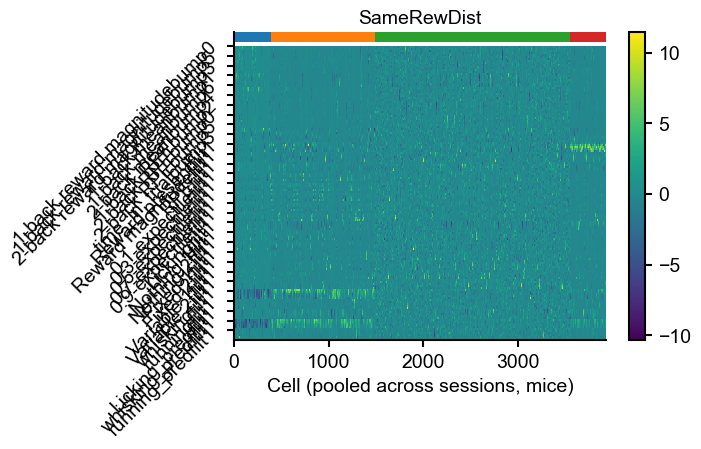

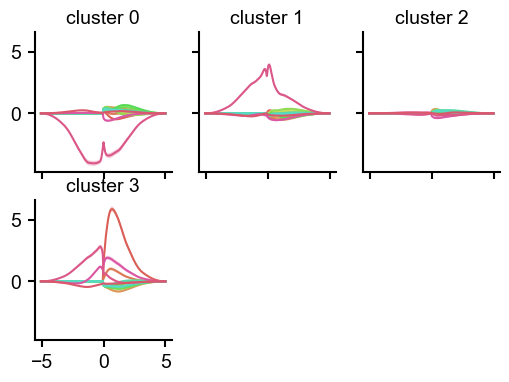

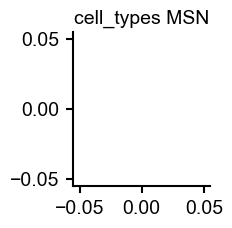

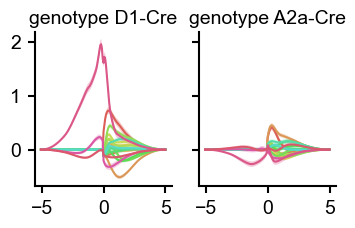

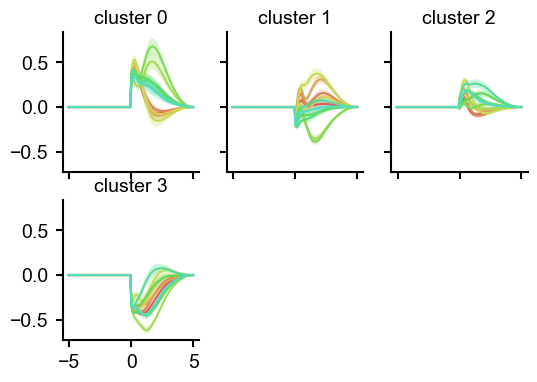

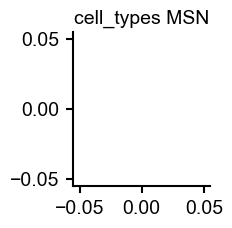

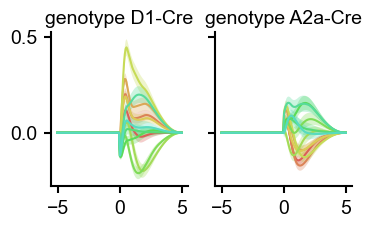

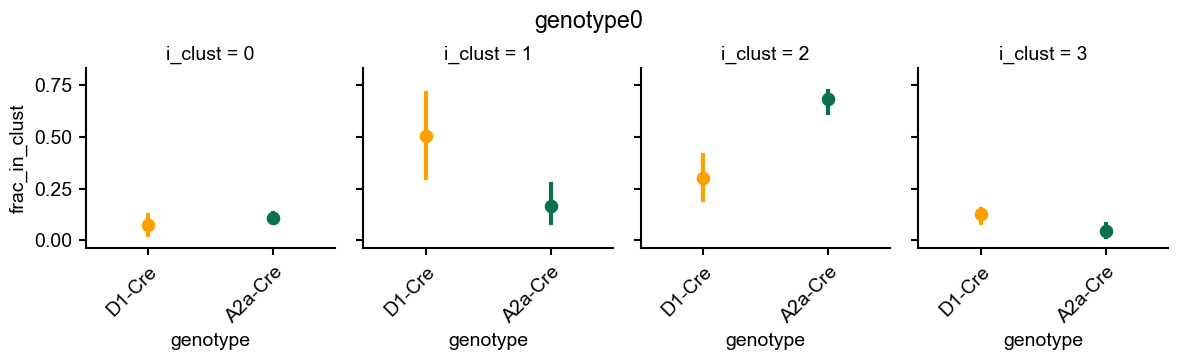

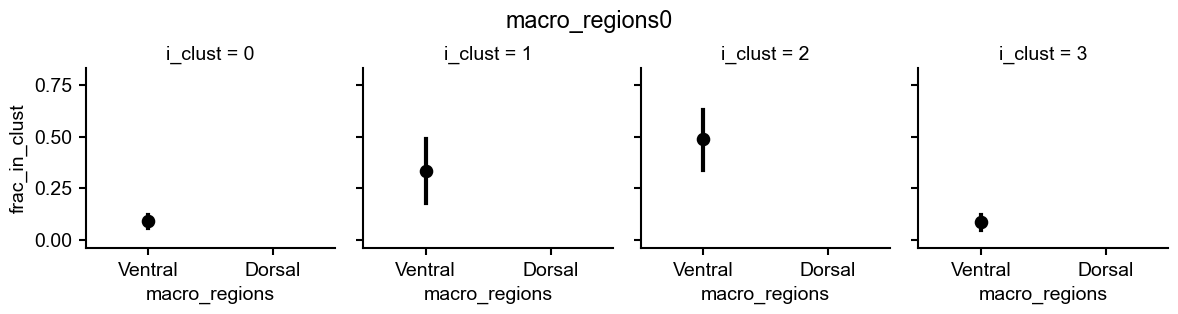

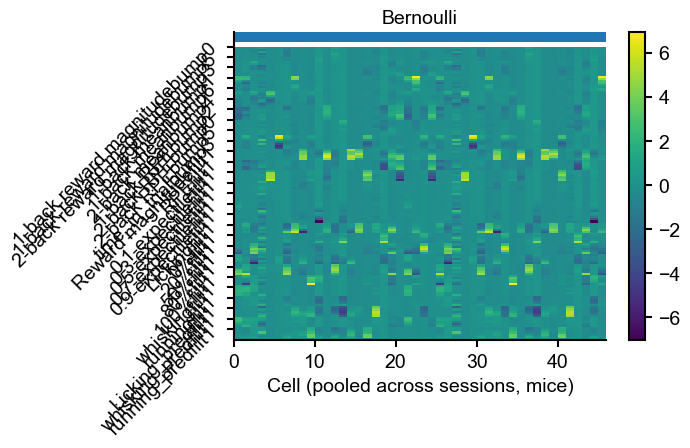

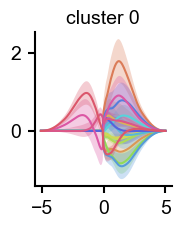

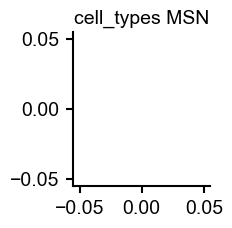

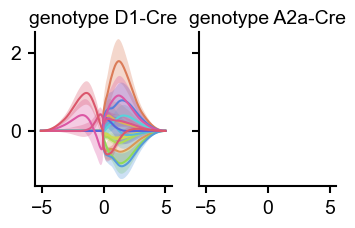

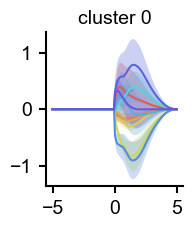

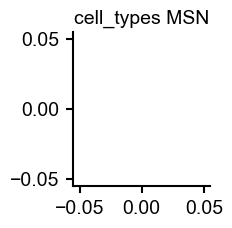

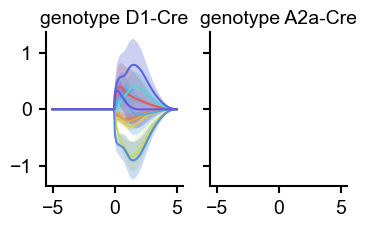

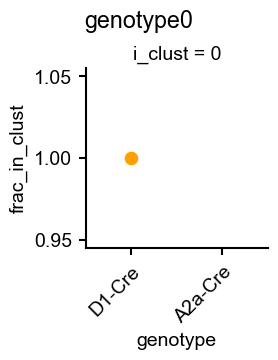

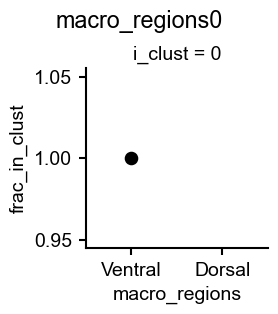

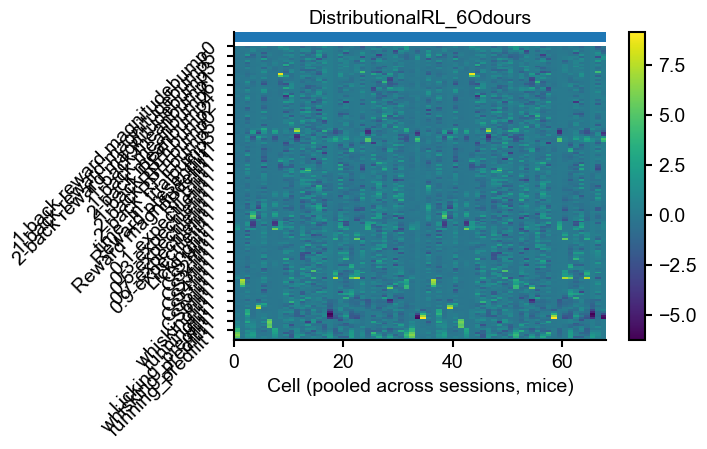

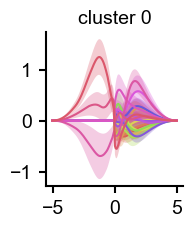

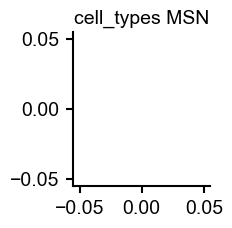

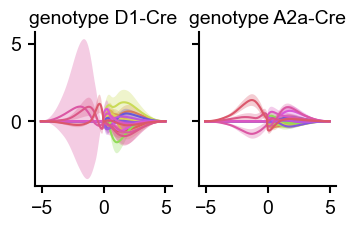

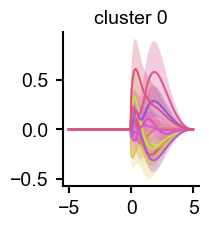

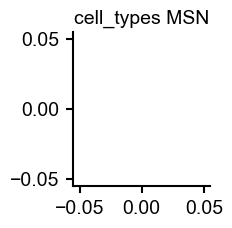

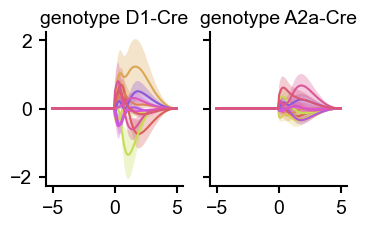

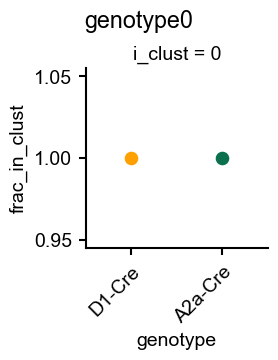

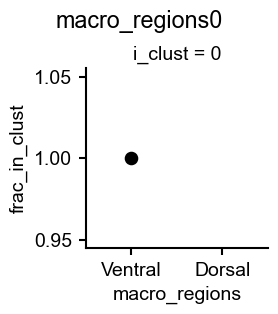

In [90]:
# predict clusters for each cell
n_comps = 3
for protocol, prot_df in coef_dfs.items():

    tmp = gmm_df.loc[np.logical_and.reduce([gmm_df['protocol'] == protocol, gmm_df['Number of PCs'] == n_comps,
                                            gmm_df['param_reg_covar'] == 0.4])].reset_index()
    n_clust = tmp.loc[np.argmin(tmp['BIC score']), 'Number of clusters']  # 
    clust_colors = sns.color_palette()[:n_clust]
    
    print(protocol, n_clust)
    
    pca = PCA(n_components=n_comps)
    col_names = prot_coefs[protocol]['labels'][0]
    coefs = np.array(prot_df[col_names])
    
    # z-score across regressors
    zcoefs = stats.zscore(coefs, axis=1)
    reduced_coefs = pca.fit_transform(zcoefs)

    gmm = GaussianMixture(n_components=n_clust, covariance_type='full', max_iter=200)
    prot_df['cluster'] = gmm.fit_predict(reduced_coefs)
    
    neworder = np.argsort(prot_df['cluster'])
    
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.pcolormesh(zcoefs[neworder, :].T)
    plt.xlabel('Cell (pooled across sessions, mice)')
    
    # since the y axis is inverted xy is actually the top left corner
    box_xs = np.insert(np.cumsum([np.sum(prot_df['cluster'] == i) for i in range(n_clust)]), 0, 0)
    max_y = len(col_names)
    rect_height = 5
    rects = [Rectangle((box_xs[j], -rect_height - 2), box_xs[j+1] - box_xs[j], rect_height) for j in range(n_clust)]
    pc = PatchCollection(rects, facecolors=clust_colors)
    ax.add_collection(pc)
    ax.set_clip_on(False)

    n_regressors = len(col_names)
    ax.set_ylim([n_regressors, -rect_height - 2])
    ax.set_yticks(np.arange(0, n_regressors, 5))
    ax.set_yticklabels(col_names[::5], rotation=45)
    plt.title(protocol)
    plt.colorbar()

    hide_spines()
    plt.savefig('./glm_figs/cluster_coef_mat_prot_{}_npcs_{}_nclust_{}_reg_{}_l1_{}.png'.format(protocol, n_comps, n_clust, reg, l1_ratio))

    # plot all conv_kernels (sensory, expectile, and motor) by cluster and by subregion!
    group_size, group_name, group_ind = parse_group_from_feature_names(col_names)
    group_name_incl = [x for x in group_name_conv if x in group_name]
    # print(group_size, group_name, group_ind)

    # Loop over all groups of temporally expanded features to compute kernels (predictive)
    all_tuning_conv = [np.sum(np.expand_dims(filts, axis = 2) * zcoefs.T[group_ind == group_name.index(this_group_name),:], axis=1) 
                    for this_group_name in group_name_conv if this_group_name in group_name]
    all_tuning_conv = np.stack(all_tuning_conv, axis = 2)
    print(all_tuning_conv.shape)
    
    # Loop over all groups of temporally expanded features to compute kernels (predictive)
    all_tuning_pred = [np.sum(np.expand_dims(pred_filts, axis = 2) * zcoefs.T[group_ind == group_name.index(this_group_name),:], axis=1) 
                     for this_group_name in group_name_pred if this_group_name in group_name]
    all_tuning_pred = np.stack(all_tuning_pred, axis = 2)
    print(all_tuning_pred.shape)

    # sum predictive kernels with their reactive companions
    pred_inds = np.array([np.any([this_group_name in x for x in group_name_pred]) for this_group_name in group_name_incl])
    # important! ensure that the relative ordering (licking, then whisking, then running) is the same here as for conv
    all_tuning_combined = all_tuning_conv.copy()
    all_tuning_combined[:, :, pred_inds] += all_tuning_pred
    
    # Plot kernels averaged within cluster, separately for each cluster
    ncols = 3
    nclust_rows = int(np.ceil(n_clust / ncols))
    ntype_rows = int(np.ceil(len(cell_types) / ncols))
    nsub_rows = int(np.ceil(len(class_labels) / ncols))
    
    for which_grps in ['all', 'sensory']:
        if which_grps == 'all':
            use_names = group_name_conv
            conv_inds = np.ones(len(group_name_conv), dtype=bool)
        else:
            use_names = sensory
            conv_inds = np.isin(group_name_conv, sensory)
        use_inds = np.array([x in group_name for x in use_names])
        conv_inds = conv_inds[np.array([x in group_name for x in group_name_conv])]

        for nrows, key, vals, name in zip([nclust_rows, ntype_rows, nsub_rows],
                                          ['cluster', 'cell_types', class_name],
                                          [np.arange(n_clust), cell_types, class_labels],
                                          ['cluster_npcs_{}_nclust_{}'.format(n_comps, n_clust), 'cell_types', class_name]):
            
            fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
            for iter in range(nrows * ncols):
                this_ax = ax.flat[iter]
                if iter < len(vals):
                    inds = prot_df[key] == vals[iter]
                    this_ax.set_prop_cycle('color', np.array(sns.color_palette("hls", len(use_names)))[use_inds])
                    this_mean = np.mean(all_tuning_combined[:, inds][..., conv_inds], axis=1)
                    this_sem = stats.sem(all_tuning_combined[:, inds][..., conv_inds], axis=1)
                    handles = this_ax.plot(filt_time, this_mean)           
                    [this_ax.fill_between(filt_time, this_mean[:, i] - this_sem[:, i], this_mean[:, i] + this_sem[:, i], alpha=0.3) for i in range(np.sum(use_inds))]
                    this_ax.set(title=f'{key} {vals[iter]}')
                else:
                    this_ax.remove()
                ax.flat[-1].legend(handles, np.array(use_names, dtype='object')[use_inds], loc=(1.04, 0), ncols=1)              
            hide_spines()
            [plt.savefig('./glm_figs/cluster_kernels_prot_{}_{}_{}_reg_{}_l1_{}.{}'.format(protocol, which_grps, name, reg, l1_ratio, fmt)) for fmt in fmts]
        
    for i_clust in range(n_clust):
        prot_df[i_clust] = prot_df['cluster'] == i_clust
    for class_label in class_labels:
        prot_df[class_label] = prot_df[class_name] == class_label
    for macro_label in ['Ventral', 'Dorsal']:
        prot_df[macro_label] = prot_df['macro_regions'] == macro_label
    
    clust_list = list(range(n_clust))
    trim_df = prot_df[prot_df['macro_regions'].notnull()]
    
    frac_per_reg2 = trim_df.groupby(['name'] + clust_list, as_index=False).mean(
        {i: 'mean' for i in class_labels}).melt(
        ['name'] + clust_list, value_vars=class_labels, var_name=class_name, value_name='frac_in_clust')
    frac_per_reg2['i_clust'] = np.where(frac_per_reg2[clust_list])[1]
    
    frac_per_reg3 = trim_df.groupby(['name'] + clust_list, as_index=False).mean(
        {i: 'mean' for i in ['Ventral', 'Dorsal']}).melt(
        ['name'] + clust_list, value_vars=['Ventral', 'Dorsal'], var_name='macro_regions', value_name='frac_in_clust')
    frac_per_reg3['i_clust'] = np.where(frac_per_reg3[clust_list])[1]
    
    for x, order, palette, df in zip([class_name, 'macro_regions'], [class_labels, ['Ventral', 'Dorsal']],
                                     [cls_palette, macro_palette], [frac_per_reg2, frac_per_reg3]):
        id_vars = ['name', x]
        frac_per_reg1 = trim_df.groupby(id_vars, as_index=False).mean({i: 'mean' for i in np.arange(n_clust)}).melt(
            id_vars, value_vars=np.arange(n_clust), var_name='i_clust', value_name='frac_in_clust')

        for i, idf in enumerate([frac_per_reg1]):  #, df]):
            g = sns.catplot(data=idf, x=x, y='frac_in_clust', hue='name', col='i_clust', order=order, kind='point', 
                            legend=False, markers=None, linewidth=1, height=3, palette=mouse_colors)
            g.map_dataframe(sns.pointplot, x=x, y='frac_in_clust', hue=x, order=order, legend=False, linestyles='', linewidth=3, palette=palette)
            if order == class_labels:
                [ax.set_xticks(np.arange(len(order))) for ax in g.axes.flat]
                [ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor') for ax in g.axes.flat]
            g.fig.suptitle(x + str(i), y=1.05)
            [plt.savefig('./glm_figs/cluster_fracs_prot_{}_by_{}_{}_reg_{}_l1_{}.{}'.format(protocol, x, i, reg, l1_ratio, fmt)) for fmt in fmts]

    

## For the time being, just use the drop_none model for everything

In [ ]:
to_drop = 'none'

# load regressor matrix
with open(os.path.join(orig_figure_path, 'regress_drop_{}.p'.format(to_drop)), 'rb') as f:
    dat = pickle.load(f)

# look for results file
pickle_path = os.path.join(orig_figure_path, 'regress_cells_drop_{}.p'.format(to_drop))
with open(pickle_path, 'rb') as f:
    container = dill.load(f)

for struct, struct_name in zip([dat, container], ['dat', 'container']):
    for var in struct.keys():
        exec("{} = {}['{}']".format(var, struct_name, var))

In [ ]:
# Make prediction on test data
y_pred = model.predict(dat['X_test'])
print(y_pred.shape)

bests = np.argsort(model.selected_frac_dev_expl_cv)[::-1]

In [ ]:
# Compare data and prediction for selected neuron
for i_neuron in bests[:10]:
    n_timepoints = 2000
    fig,ax = plt.subplots(figsize = (16,3))
    plt.plot(np.arange(n_timepoints)*neural.dt, y_test[:n_timepoints, i_neuron], 'k', lw = 0.5, label = 'data')
    plt.plot(np.arange(n_timepoints)*neural.dt, y_pred[:n_timepoints, i_neuron], 'r', lw = 0.75, label = 'prediction')
    plt.xlabel('Time (sec)')
    plt.ylabel('Spikes')
    plt.legend()
    print(f'Fraction deviance explained = {frac_dev_expl[i_neuron]:.2f}')

## Quantify feature importance/contribution

Besides evaluating the model performance based on fraction deviance explained, we often want to know the importance or contribution of different variables in explaining a neuron's activity, and then compare across different neurons. There are several ways to assess a variable's contribution. One way is to look at the **model weights (coefficients)** directly. Alternately, we can evaluate the **"fraction null deviance"** or **"fraction explained deviance"** of each variable using different procedures. There are pros and cons of different ways and they are complementary to each other. In this section, we will see how to perform these different ways to quantify feature importance/contribution.

### Model weights (coefficients)

The model weights (coefficients) provide an easy access to the magnitude and directionality (because they are signed) of how a variable modulates the response. In the context of neural activity, the model weights describe the "tuning" of the neuron to the variables of interests. Here we will demonstrate how to extract and visualize fitted model weights; specifically, we will compute the "tuning function" (or "kernel") of a feature group, by multiplying the fitted weight of each expanded feature with the basis functions and summing them up. Note that these are the linear kernels before the activation function is applied. Recall that in the Poisson GLM models:

$ y = exp(Xw + w_0)$

The weights work as a multiplicative factors (gains) after passing through the activation function, i.e. they amplify or suppress the response $y$ on top of a baseline value (baseline firing rate of a neuron). To get the gains, you need to exponentiate these kernels.




In [ ]:
# Plot position kernel for the first neuron
# Identify indices for position bases
this_group_name = '1-back reward magnitude'
    
these_ind = group_ind == group_name.index(this_group_name)

# Grab corresponding weights
weights = model.selected_w[these_ind, i_neuron]

# Reconstruct tuning function
tuning = np.sum((bases * weights), axis=1)

# Visualize the position kernel as a function of maze position
fig, ax = plt.subplots()
ax.plot(timebase, tuning, 'k')
ax.set(xlabel = 'Time from CS');

(300, 529)


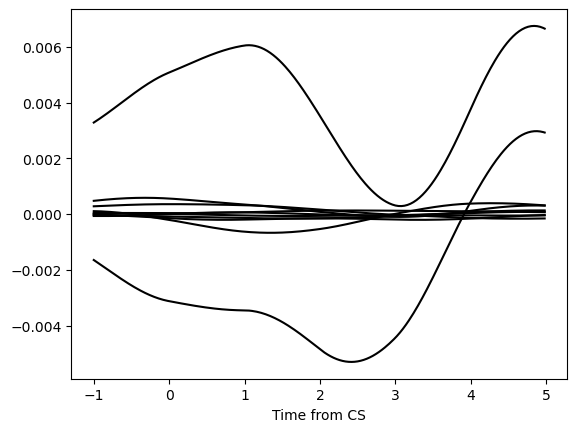

In [51]:
# Compute position kernels for all neurons
weights = model.selected_w[these_ind,:]
all_tuning = np.sum(np.expand_dims(bases, axis = 2)*weights,axis=1)
print(all_tuning.shape)

# Plot position kernels for the first 10 neurons
n_selected_neurons = 10
fig, ax = plt.subplots()
ax.plot(timebase, all_tuning[:,:n_selected_neurons], 'k')
ax.set(xlabel = 'Time from CS');

We then loop over all position expanded task variables to obtained kernels for all the position expanded task variables for all neurons.

In [52]:
# Get group names for all temporal features
group_name_tm = [
     '1-back reward magnitude',
     '2-back reward magnitude',
     '3-back reward magnitude',
     '4-back reward magnitude',
     '5-back reward magnitude',
     '1-back mean',
     '2-back mean',
     '3-back mean',
     '4-back mean',
     '5-back mean',
     '1-back RPE',
     '2-back RPE',
     '3-back RPE',
     '4-back RPE',
     '5-back RPE',
     'time_in_trial',
]

# Extract all model weights
all_weights = model.selected_w

# Loop over all groups of temporally expanded features to compute kernels
all_tuning_tm = [np.sum(np.expand_dims(bases, axis = 2) * all_weights[group_ind == group_name.index(this_group_name),:], axis=1) 
                  for this_group_name in group_name_tm]
all_tuning_tm = np.stack(all_tuning_tm, axis = 2)
print(all_tuning_tm.shape)

(300, 529, 16)


In [53]:
# Get group names for all convolved features
group_name_conv = [
    'Reward present',
 'Reward magnitude',
 'RPE'] + ['{:.1f}-expectile'.format(tau) for tau in taus] + \
 ['Licking',
 'Nothing 1',
 'Nothing 2',
 'Fixed 1',
 'Fixed 2',
 'Variable 1',
 'Variable 2',
 'whisking',
 'running',
]

# Loop over all groups of temporally expanded features to compute kernels
all_tuning_conv = [np.sum(np.expand_dims(filts, axis = 2) * all_weights[group_ind == group_name.index(this_group_name),:], axis=1) 
                for this_group_name in group_name_conv]
all_tuning_conv = np.stack(all_tuning_conv, axis = 2)
print(all_tuning_conv.shape)

(534, 529, 13)


In [54]:
group_name_pred = [
    'Licking_pred',
     'whisking_pred',
     'running_pred'
]

# Loop over all groups of temporally expanded features to compute kernels
all_tuning_pred = [np.sum(np.expand_dims(pred_filts, axis = 2) * all_weights[group_ind == group_name.index(this_group_name),:], axis=1) 
                for this_group_name in group_name_pred]
all_tuning_pred = np.stack(all_tuning_pred, axis = 2)
print(all_tuning_pred.shape)

(534, 529, 3)


Same as `all_tuning_tm`, here `all_tuning_conv` contains all kernels for convolved features for all neurons, arranged as (n_timepoints, n_cells, n_task_variables). Note that n_timepoints was defined earlier when we created and visualized the temporal basis functions `filts`, and you can arbitrarily change the number of points (between 0 and 5 sec)  with ideal resolution you want.

In [55]:
all_tuning_tm.shape

(300, 529, 16)

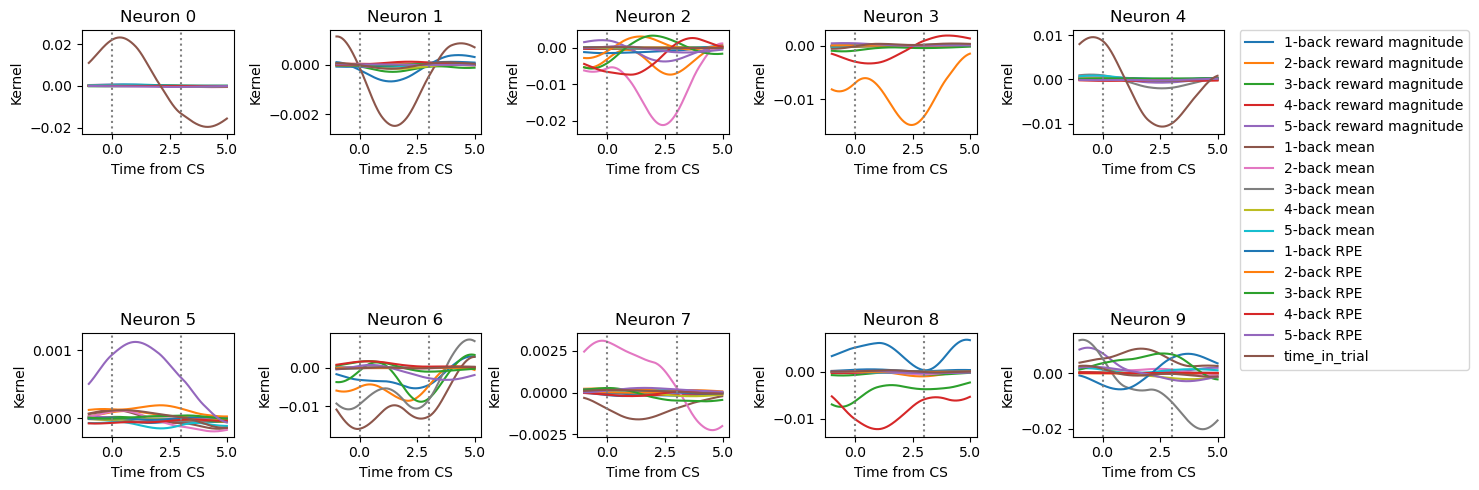

In [56]:
fig, ax = plt.subplots(2,5,figsize=(15,5))
for i_neuron in range(n_selected_neurons):
    this_ax = ax[i_neuron//5,i_neuron%5]
    this_ax.plot(timebase, all_tuning_tm[:,i_neuron,:])
    this_ax.set(xlabel='Time from CS',ylabel='Kernel',title=f'Neuron {i_neuron}')
    if i_neuron == 4:
        this_ax.legend(group_name_tm, bbox_to_anchor=(1.1, 1),
                       loc='upper left', borderaxespad=0.)
    ymin, ymax = this_ax.get_ylim()
    this_ax.vlines(0, 1.05*ymin, 1.05*ymax, color='gray',ls=':')
    this_ax.vlines(3, 1.05*ymin, 1.05*ymax, color='gray',ls=':')
    this_ax.set(ylim=[1.05*ymin, 1.05*ymax])

plt.tight_layout()

Alternately, we can plot all the tuning functions of different neurons in the same plots to compare the diversity of tuning of a particular variable across neurons.

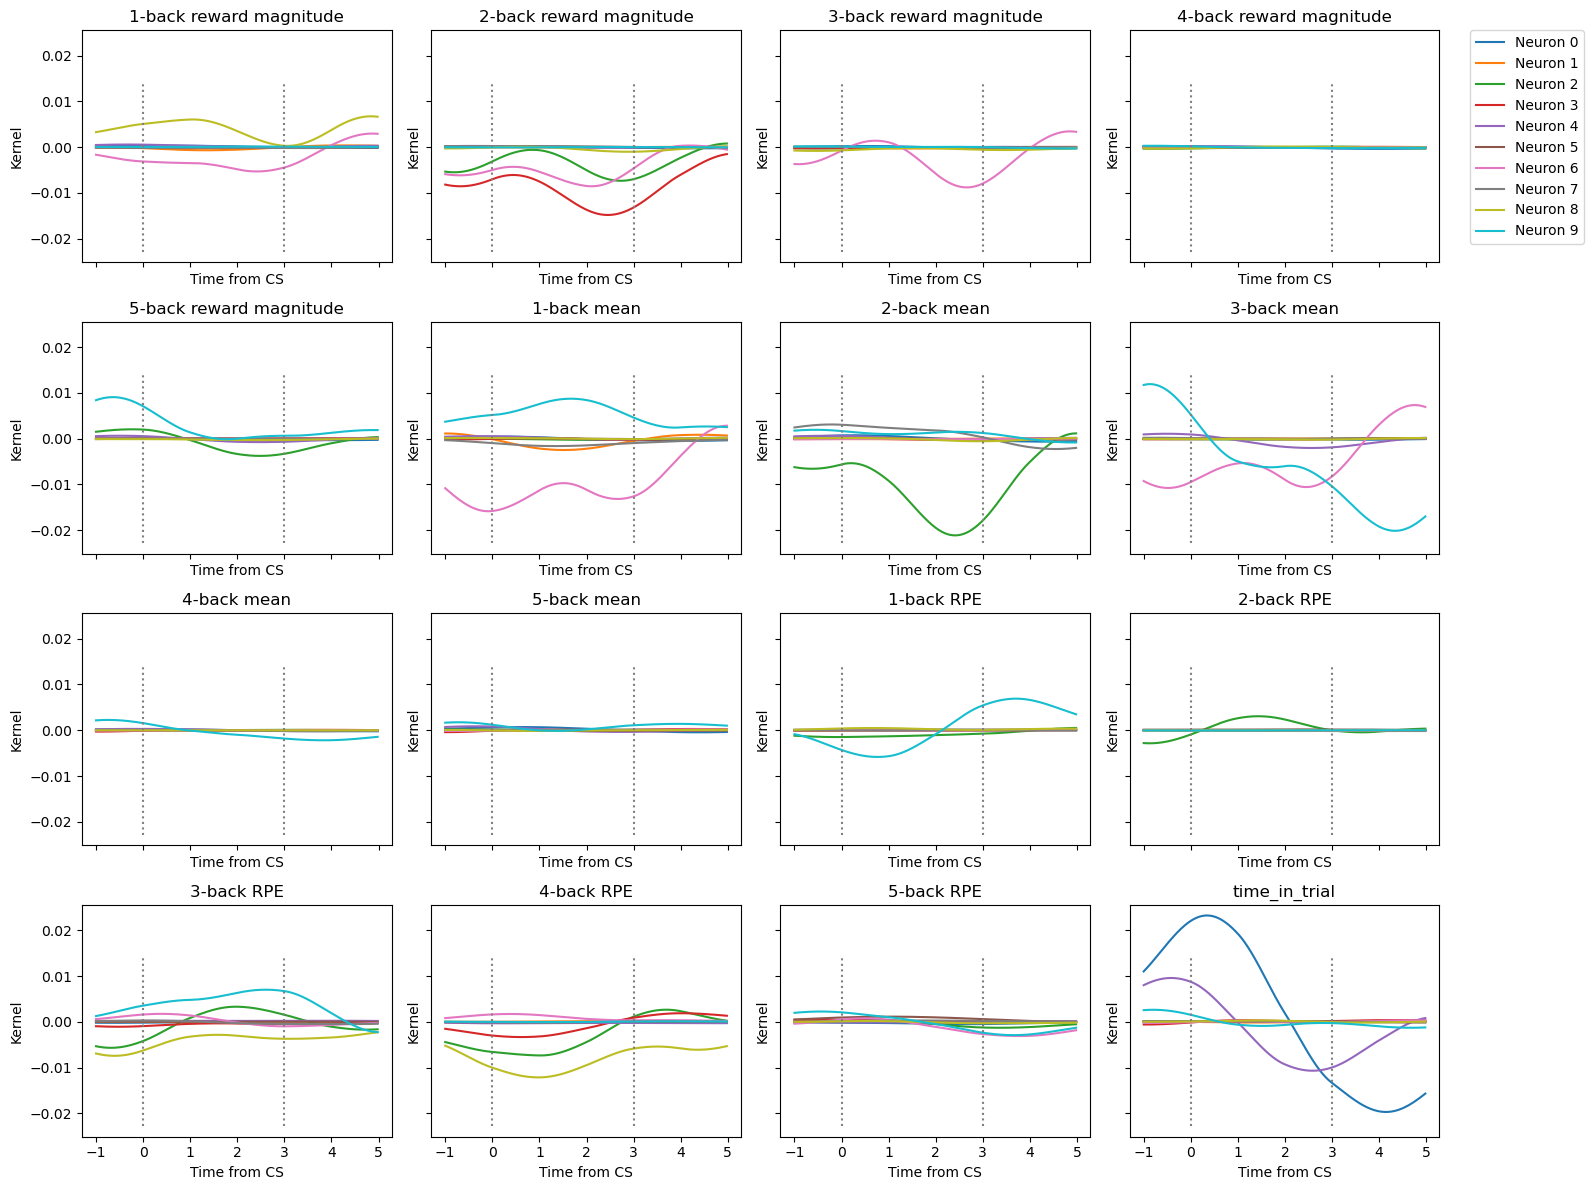

In [57]:
# Visualize kernels for position expanded task variables for first 10 neurons (one variable per plot)
n_selected_neurons = 10
fig, ax = plt.subplots(4,4,figsize=(16,12), sharex=True, sharey=True)
for i_group, this_group_name in enumerate(group_name_tm):
    this_ax = ax[i_group//4,i_group%4]
    this_ax.plot(timebase, all_tuning_tm[:,:n_selected_neurons,i_group])
    this_ax.set(xlabel='Time from CS',ylabel='Kernel',title=group_name_tm[i_group])
    # ymin, ymax = this_ax.get_ylim()
    this_ax.vlines(0, 1.05*ymin, 1.05*ymax, color='gray',ls=':')
    this_ax.vlines(3, 1.05*ymin, 1.05*ymax, color='gray',ls=':')
    # this_ax.set(ylim=[1.05*ymin, 1.05*ymax])

    if i_group == 3:
        this_ax.legend([f'Neuron {i}' for i in range(n_selected_neurons)], bbox_to_anchor=(1.1, 1),
                       loc='upper left', borderaxespad=0.)

plt.tight_layout()

To evaluate the overall strength of tuning irrespective of the directionality (sign) of tuning, we can take the absolute value of the kernels. Here we further take an average of the absolute value of kernels across all neurons to show a overall tuning profile of this neural population.

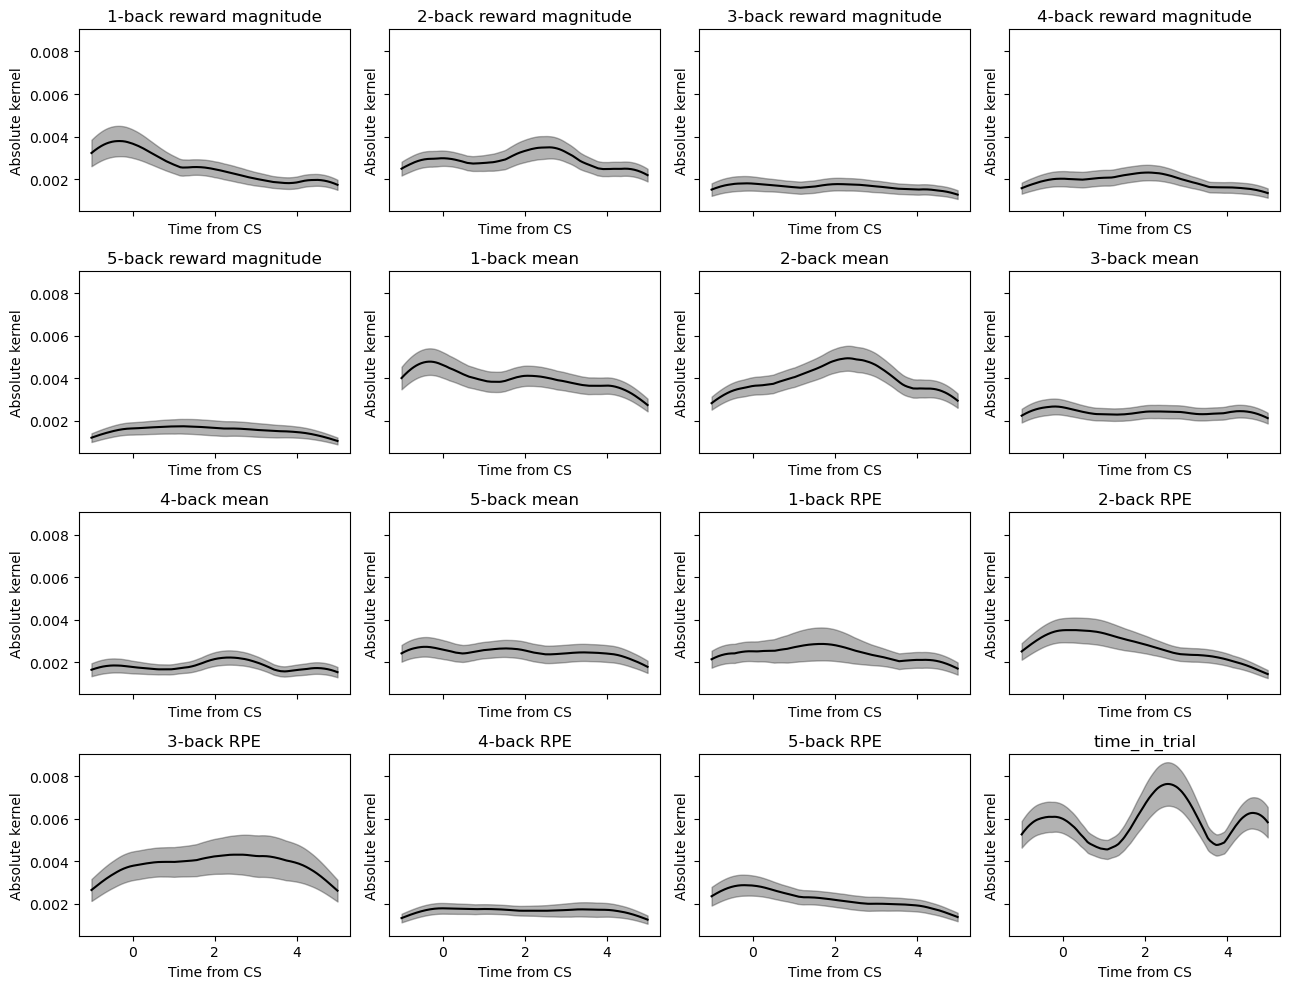

In [58]:
# Plot mean absolute kernel values during maze traversal
fig, ax = plt.subplots(4,4,figsize=(13,10), sharex=True, sharey=True)
for i_group, this_group_name in enumerate(group_name_tm):
    this_mean = np.abs(all_tuning_tm[:,:,i_group]).mean(axis=-1)
    this_sem = np.abs(all_tuning_tm[:,:,i_group]).std(axis=-1)/np.sqrt(n_cells)
    this_ax = ax[i_group//4,i_group%4]
    this_ax.plot(timebase, this_mean,'k')
    this_ax.fill_between(timebase, this_mean - this_sem, this_mean + this_sem, color='k',alpha=0.3)
    this_ax.set(xlabel='Time from CS',ylabel='Absolute kernel',title=group_name_tm[i_group])
                # ylim=[0, 1.1*(this_mean + this_sem).max()])

plt.tight_layout()

We can visualize the average absolute kernels of convolved task variables too. Again pay attention to the magnitude and shape of the curve for each variable, and compare that with those temporally expanded variables.

In [59]:
all_tuning_combined = np.concatenate((all_tuning_conv, all_tuning_pred), axis=2)
group_name_combined = group_name_conv + group_name_pred

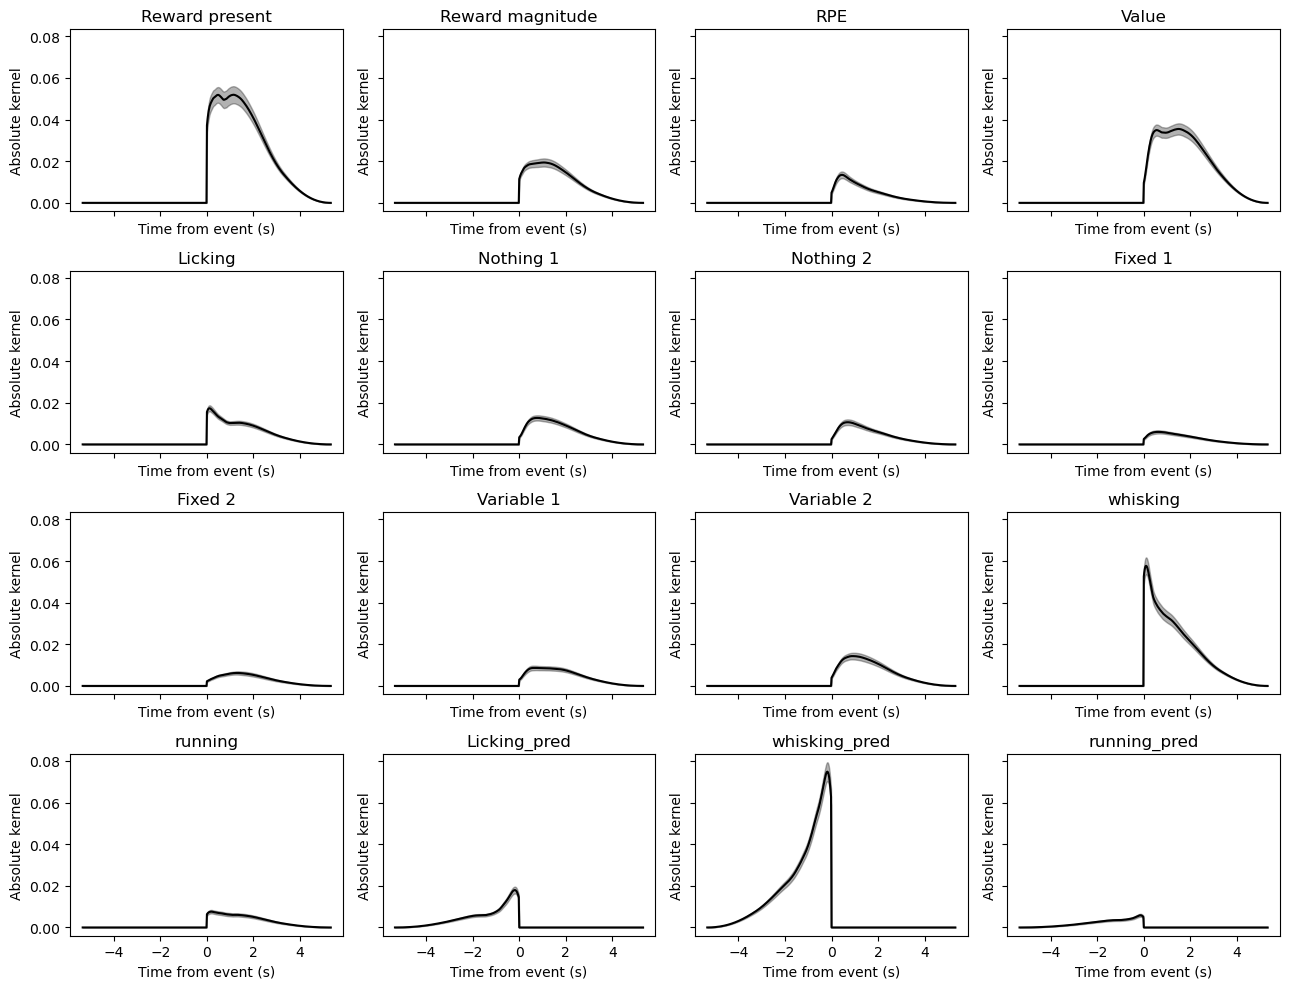

In [60]:
# Plot mean absolute kernel values
fig, ax = plt.subplots(4,4,figsize=(13,10), sharex=True, sharey=True)
for i_group, this_group_name in enumerate(group_name_combined):
    this_mean = np.abs(all_tuning_combined[:,:,i_group]).mean(axis=-1)
    this_sem = np.abs(all_tuning_combined[:,:,i_group]).std(axis=-1)/np.sqrt(n_cells)
    this_ax = ax[i_group//4,i_group%4]
    this_ax.plot(filt_time, this_mean,'k')
    this_ax.fill_between(filt_time, this_mean - this_sem, this_mean + this_sem, color='k',alpha=0.3)
    # this_ax.vlines([1,3], 0, 1.1*(this_mean + this_sem).max(), color='gray',ls=':')
    this_ax.set(xlabel='Time from event (s)',ylabel='Absolute kernel',title=group_name_combined[i_group])
                # ylim=[0, 1.1*(this_mean + this_sem).max()])

plt.tight_layout()

### Model breakdown procedure for feature contribution

The first method we can compute feature contribution with **fraction null deviance** or **fraction explained deviance** for each variable is to perform what we call **"model breakdown"** procedure, which does not require re-fitting a new model. In gist, we evaluate the model deviance of the original model (**"full model"**) and that of an **"ablated model"** in which we remove the variable we want to evaluate on. We then compute the difference between the model deviance, and normalized it by the null deviance to compute the "fraction null deviance", or by the explained deviance of the full model to compute the "fraction explained deviance". 
*(Don't confuse this term with "fraction deviance explained" when we report model performance; "fraction deviance explained" means how much null deviance is explained by the full model, whereas "fraction explained deviance" means how much of the explained deviance of the full model is contributed by a the variable we remove in the ablated model.)* 

In principle, it's best to perform model breakdown procedure on test data. However, we only preserve 15% of all data as test data, which is a small portion. We want to perform model breakdown procedure with more data, so we turn to use the CV held-out data instead. For each CV fold, we have 1/5 of training data used as held-out data, and across all folds we have all the 85% of data (i.e. all training data) served as held-out. 

To evaluate model breakdown procedure on CV held-out data, we need to make prediction of the full model and ablated model for each fold separately, on the held-out data of that fold, using the fitted weights of that fold (trained on 4/5 of the data). We can't use the `selected_w` from the model directly since those are weights trained on all training data in the final round. Luckily, the indices of held-out data and the fold-specific fitted weights are saved by the GLM_CV model, and we can call the method `make_prediction_cv` on X_train or X_ablated (same as X_train but with some variables zeroed or shuffled) to make prediction with the full model or ablated models on CV held-out data. We can then use those predictions to compute model deviance, take the difference, and normalize by null deviance or explained deviance to compute fraction null deviance or fraction explained deviance.

First, we evaluate the null deviance on training data by calling a utility function in the `glm` module called `pointwise_null_deviance`. Here is the documentation of the function.



```
def pointwise_null_deviance(y, loss_type = 'poisson'):
    '''
    Compute pointwise null deviance for data with given loss type 
    Input parameters::
    y: input data, ndarray
    loss_type: {'gaussian', 'poisson', 'binominal'}, default = 'poisson'

    Returns::
    dev: pointwise deviance value, ndarray of shape of y
    '''
```



In [61]:
def tm_binning(X, time_in_trial, tm_centers, tm_half_width):
    '''
    Bin input X by time

    Input parameters::
    X: variable for binning, ndarray
    time_in_trial: position for each point in X, ndarray of shape (X.shape[0],)
    tm_centers: center locations for time bins, ndarray
    tm_half_width: half width of time bins, float

    Returns:
    X_tm: time-binned X, ndarray of shape (n_tm_bins, X.shape[1])
    '''
    # Sanity check and prelocate
    if X.ndim == 1:
        X = X.reshape(-1,1)
    X_tm = np.full((tm_centers.shape[0],X.shape[1]),np.NaN)
    
    # Calcuate time-binned X  
    for tm_ind, tm_cent in enumerate(tm_centers):
        these_frames = np.logical_and(time_in_trial > (tm_cent - tm_half_width), time_in_trial < (tm_cent + tm_half_width))
        X_tm[tm_ind,:] = np.mean(X[these_frames,:], axis = 0)

    return X_tm

In [62]:
basis_half_width = np.max(np.diff(basis_centers)) / 2
bin_centers = np.array(basis_centers[:-1] + basis_half_width, dtype=int)
tm_half_width = basis_half_width * neural.dt
tm_centers = timebase[bin_centers]

In [63]:
# Extract time_in_trial for training data (used in binning)
time_in_trial_train = time_in_trial[train_idx]

# Compute pointwise null deviance 
null_dev = glm.pointwise_null_deviance(y_train, loss_type = model.loss_type)

# Bin null deviance into position and time bins
null_dev_tm = tm_binning(null_dev, time_in_trial_train, tm_centers, tm_half_width)
print(null_dev.shape, null_dev_tm.shape)

(72750, 529) (6, 529)


`null_dev` is in shape of (n_timepoints, n_cells) and `null_dev_tm` is in shape of (n_time_bins, n_cells).


Next we call `make_prediction_cv` method on X_train to make prediction with the full model, compute the model deviance using the utility function `pointwise_deviance` in `glm` module, and the bin the model deviance.

Here is the documentation of the function:


```
def pointwise_deviance(y_true, y_pred, loss_type = 'poisson'):
    '''
    Compute pointwise deviance for data with given loss type 
    Input parameters::
    y_true: true values, ndarray
    y_pred: predicted values, ndarray
    loss_type: {'gaussian', 'poisson', 'binominal'}, default = 'poisson'

    Returns::
    dev: pointwise deviance value, ndarray of shape of y_true and y_pred
    '''
```



In [64]:
# Make prediction of X_train (full model) on CV held-out data
pred_full_cv = model.make_prediction_cv(X_train)

# Compute pointwise model deviance with the prediction and ground truth Y
model_dev_full = glm.pointwise_deviance(y_train, pred_full_cv, loss_type = model.loss_type)

# Bin full model deviance into position and time bins
model_dev_tm = tm_binning(model_dev_full, time_in_trial_train, tm_centers, tm_half_width)
print(model_dev_full.shape, model_dev_tm.shape)

(72750, 529) (6, 529)


`model_dev_full` is in shape of (n_timepoints, n_cells) and `model_dev_tm` is in shape of (n_time_bins, n_cells).

Then we perform model breakdown procedure. First we identify feature groups and their indices, zero corresponding values in X_train to generate X_ablated, make prediction on CV held-out data, and compute model deviance for ablated models. We then compute the difference in model deviance between ablated and full model, and bin the difference into time bins.

In [82]:
with open('/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/neural-plots/AL54/20220426/regress_drop_none.p', 'rb') as f:
    dat = pickle.load(f)

In [83]:
dat['group_name']

['1-back reward magnitude',
 '2-back reward magnitude',
 '1-back mean',
 '2-back mean',
 '1-back RPE',
 '2-back RPE',
 'time_in_trial',
 'Reward present',
 'Reward magnitude',
 'RPE',
 '0.1-expectile',
 '0.3-expectile',
 '0.5-expectile',
 '0.7-expectile',
 '0.9-expectile',
 'Licking',
 'Nothing 1',
 'Nothing 2',
 'Fixed 1',
 'Fixed 2',
 'Variable 1',
 'Variable 2',
 'whisking',
 'running',
 'Licking_pred',
 'whisking_pred',
 'running_pred',
 'pupil',
 'mot_svd',
 'nuissance']

In [84]:
dat['group_ind']

array([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,
        7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14,
       14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17,
       17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20,
       21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24,
       24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29])

In [65]:
## Perform model breakdown procedure
all_var = [] # to keep new feature group (variable) names
all_diff_dev_tm = [] # to keep all time binned difference in model deviance for all variables
all_diff_dev_avg = [] # to keep all mean difference in model deviance for all variables

# Loop over feature groups and perform model breakdown 
for ind, group in enumerate(group_name):
    X_ablated = X_train.copy()

    ablate_ind = [this_ind in [ind] for this_ind in group_ind]
    if 'pred' not in group:
        all_var.append(group)
    else:  # Skip the pred groups since they've been ablated with their non-pred counterparts
        continue
        
    if 'Licking' in group or 'whisking' in group or 'running' in group:
        ind_pred = group_name.index(group + '_pred') 
        pred_ind = [this_ind in [ind_pred] for this_ind in group_ind]
        ablate_ind = np.logical_or(ablate_ind, pred_ind)

    print(group)
    print(np.array(labels, dtype=object)[ablate_ind])
    
    # Put ablated features to 0 (you can do random shuffling here instead)
    X_ablated[:,ablate_ind] = 0
    
    # Make prediction on X_ablated (on CV held-out data)
    this_pred_ablated = model.make_prediction_cv(X_ablated)  

    # Compute pointwise deviance for the ablated model
    model_dev_ablated = glm.pointwise_deviance(y_train, this_pred_ablated, loss_type = model.loss_type)

    # Compute deviance difference between ablated model and full model
    diff_dev = model_dev_ablated - model_dev_full

    # Take average difference in deviance
    diff_dev_avg = np.mean(diff_dev, axis = 0)

    # Compute position/temporally aligned difference in deviance
    diff_dev_tm = tm_binning(diff_dev, time_in_trial_train, tm_centers, tm_half_width)

    all_diff_dev_tm.append(diff_dev_tm)
    all_diff_dev_avg.append(diff_dev_avg)    

all_diff_dev_tm = np.stack(all_diff_dev_tm, axis = 2)
all_diff_dev_avg = np.stack(all_diff_dev_avg, axis = 1)

print(all_diff_dev_tm.shape, all_diff_dev_avg.shape)

1-back reward magnitude
['1-back reward magnitudebump0' '1-back reward magnitudebump1'
 '1-back reward magnitudebump2' '1-back reward magnitudebump3'
 '1-back reward magnitudebump4' '1-back reward magnitudebump5'
 '1-back reward magnitudebump6']
2-back reward magnitude
['2-back reward magnitudebump0' '2-back reward magnitudebump1'
 '2-back reward magnitudebump2' '2-back reward magnitudebump3'
 '2-back reward magnitudebump4' '2-back reward magnitudebump5'
 '2-back reward magnitudebump6']
3-back reward magnitude
['3-back reward magnitudebump0' '3-back reward magnitudebump1'
 '3-back reward magnitudebump2' '3-back reward magnitudebump3'
 '3-back reward magnitudebump4' '3-back reward magnitudebump5'
 '3-back reward magnitudebump6']
4-back reward magnitude
['4-back reward magnitudebump0' '4-back reward magnitudebump1'
 '4-back reward magnitudebump2' '4-back reward magnitudebump3'
 '4-back reward magnitudebump4' '4-back reward magnitudebump5'
 '4-back reward magnitudebump6']
5-back reward ma

In [66]:
# Check feature group names (variables)
all_var

['1-back reward magnitude',
 '2-back reward magnitude',
 '3-back reward magnitude',
 '4-back reward magnitude',
 '5-back reward magnitude',
 '1-back mean',
 '2-back mean',
 '3-back mean',
 '4-back mean',
 '5-back mean',
 '1-back RPE',
 '2-back RPE',
 '3-back RPE',
 '4-back RPE',
 '5-back RPE',
 'time_in_trial',
 'Reward present',
 'Reward magnitude',
 'RPE',
 'Value',
 'Licking',
 'Nothing 1',
 'Nothing 2',
 'Fixed 1',
 'Fixed 2',
 'Variable 1',
 'Variable 2',
 'whisking',
 'running',
 'pupil',
 'mot_svd',
 'nuissance']

Now we can compute fraction null deviance and fraction explained deviance (of the full model). Note that here we perform some extra capping to keep things nice and numerically stable. For example, explained deviance can be negative since we're evaluating it on the held-out data, but we can cap it at 0. 

For fraction explained deviance, we're capping the time binned deviance difference by time binned explained deviance as upper bound, and then divide it by the "average explained deviance" across all datapoints. This means that for some position or time bin, the value can exceed 1 since the amount of explained deviance may vary across different bins. Therefore, the "average explained deviance" serves as a "normalization factor" here, and we're not asking for true bin-wise fraction explained deviance. One can tailor this process with their need, such as normalizing time-binned deviance difference by average explained deviance across all time bins, etc. 

Similarly, for null explained deviance, we're capping the time binned deviance difference by time binned null deviance as upper bound, and then divide it by the "average null deviance" across all datapoints as a "normalization factor". One can also tailor this process by normalizing time-binned deviance difference by average null deviance across all time bins, etc. 

Lastly, here I'm not capping the deviance difference to be non-negative. If you do so, you may introduce a small positive bias into the fraction explained deviance or fraction null deviance, and make the mean across a neural population seem positive even if it's not. You can, instead, cap it at some negative number, such as -1, to stablize the value when you take the mean over a population of neurons. Also pay attention to the denominators (null deviance or explained deviance), if it gets close to zero, you may need to handle it specifically for numerical stability.

In [67]:
# Compute time binned explained deviance of the full model (capped by 0) for each neuron
expl_dev_tm = np.maximum(null_dev_tm - model_dev_tm, 0)

# Compute average null deviance and explained deviance (used as normalizing factors in the next steps) for each neuron, averaged across
# all time points
null_dev_avg = np.mean(null_dev, axis = 0)
expl_dev_avg = np.mean(null_dev - model_dev_full, axis = 0)

# Compute fraction explained deviance (capped by time binned explained deviance, then normalized by average explained deviance)
# all_diff_dev_tm contains  dev_ablated_model - dev_full_model
# expl_dev_tm contains dev_null_model - dev_full_model
# expl_dev_tm will therefore tend to be large, because we expect the null deviance to be much higher than the full model deviance
# if all_diff_dev_tm is small, it tells us that there isn't much effect of the ablation, so frac_expl_dev_tm will be close to zero
frac_expl_dev_tm = np.minimum(all_diff_dev_tm, expl_dev_tm[:,:,np.newaxis])/expl_dev_avg[np.newaxis,:,np.newaxis]
# # Cap deviance different at -1 if needed
# frac_expl_dev_tm = np.minimum(np.maximum(all_diff_dev_tm,-1),expl_dev_tm[:,:,np.newaxis])/expl_dev_avg[np.newaxis,:,np.newaxis]

# Compute fraction null deviance (capped by time binned null deviance, then normalized by average null deviance)
frac_null_dev_tm = np.minimum(all_diff_dev_tm, null_dev_tm[:,:,np.newaxis])/null_dev_avg[np.newaxis,:,np.newaxis]
# # Cap deviance different at -1 if needed
# frac_null_dev_tm = np.minimum(np.maximum(all_diff_dev_tm,-1),null_dev_tm[:,:,np.newaxis])/null_dev_avg[np.newaxis,:,np.newaxis]

Finally, we can visualize the fraction null deviance and fraction explained deviance as mean over all 100 neurons as a function of time in the trial. Now the y values are easier to interpret and comparable between variables. The values for fraction null deviance is always smaller than fraction explained deviance, since the denominators, explained deviance is bounded by and smaller than null deviance. Also note that for movement variables, even if we didn't fit them with temporal basis expansion, we can still evaluate the fraction null or explained deviance as a function of time. 

You can compare these plots to the plots with average absolute kernels. The shape of the curves (time-specificity) for each variable are generally consistent. If you look at the average absolute kernels, it appeared to be a small positive value since we took the absolute value of the kernels.

Some things that make sense:
1. "Reward present", "Reward magnitude", and "RPE" are high in reward period
2. "Value" and odor-specific regressors are especially high in the odor period.
   - I might have predicted that the value regressor would stay high longer, but I guess not
3. Effect of whisking and licking tend to ramp up during the trial
4. Nuissance regressors are constant over the course of the trial, as expected
5. Motion SVD and nuissance effects are relatively large


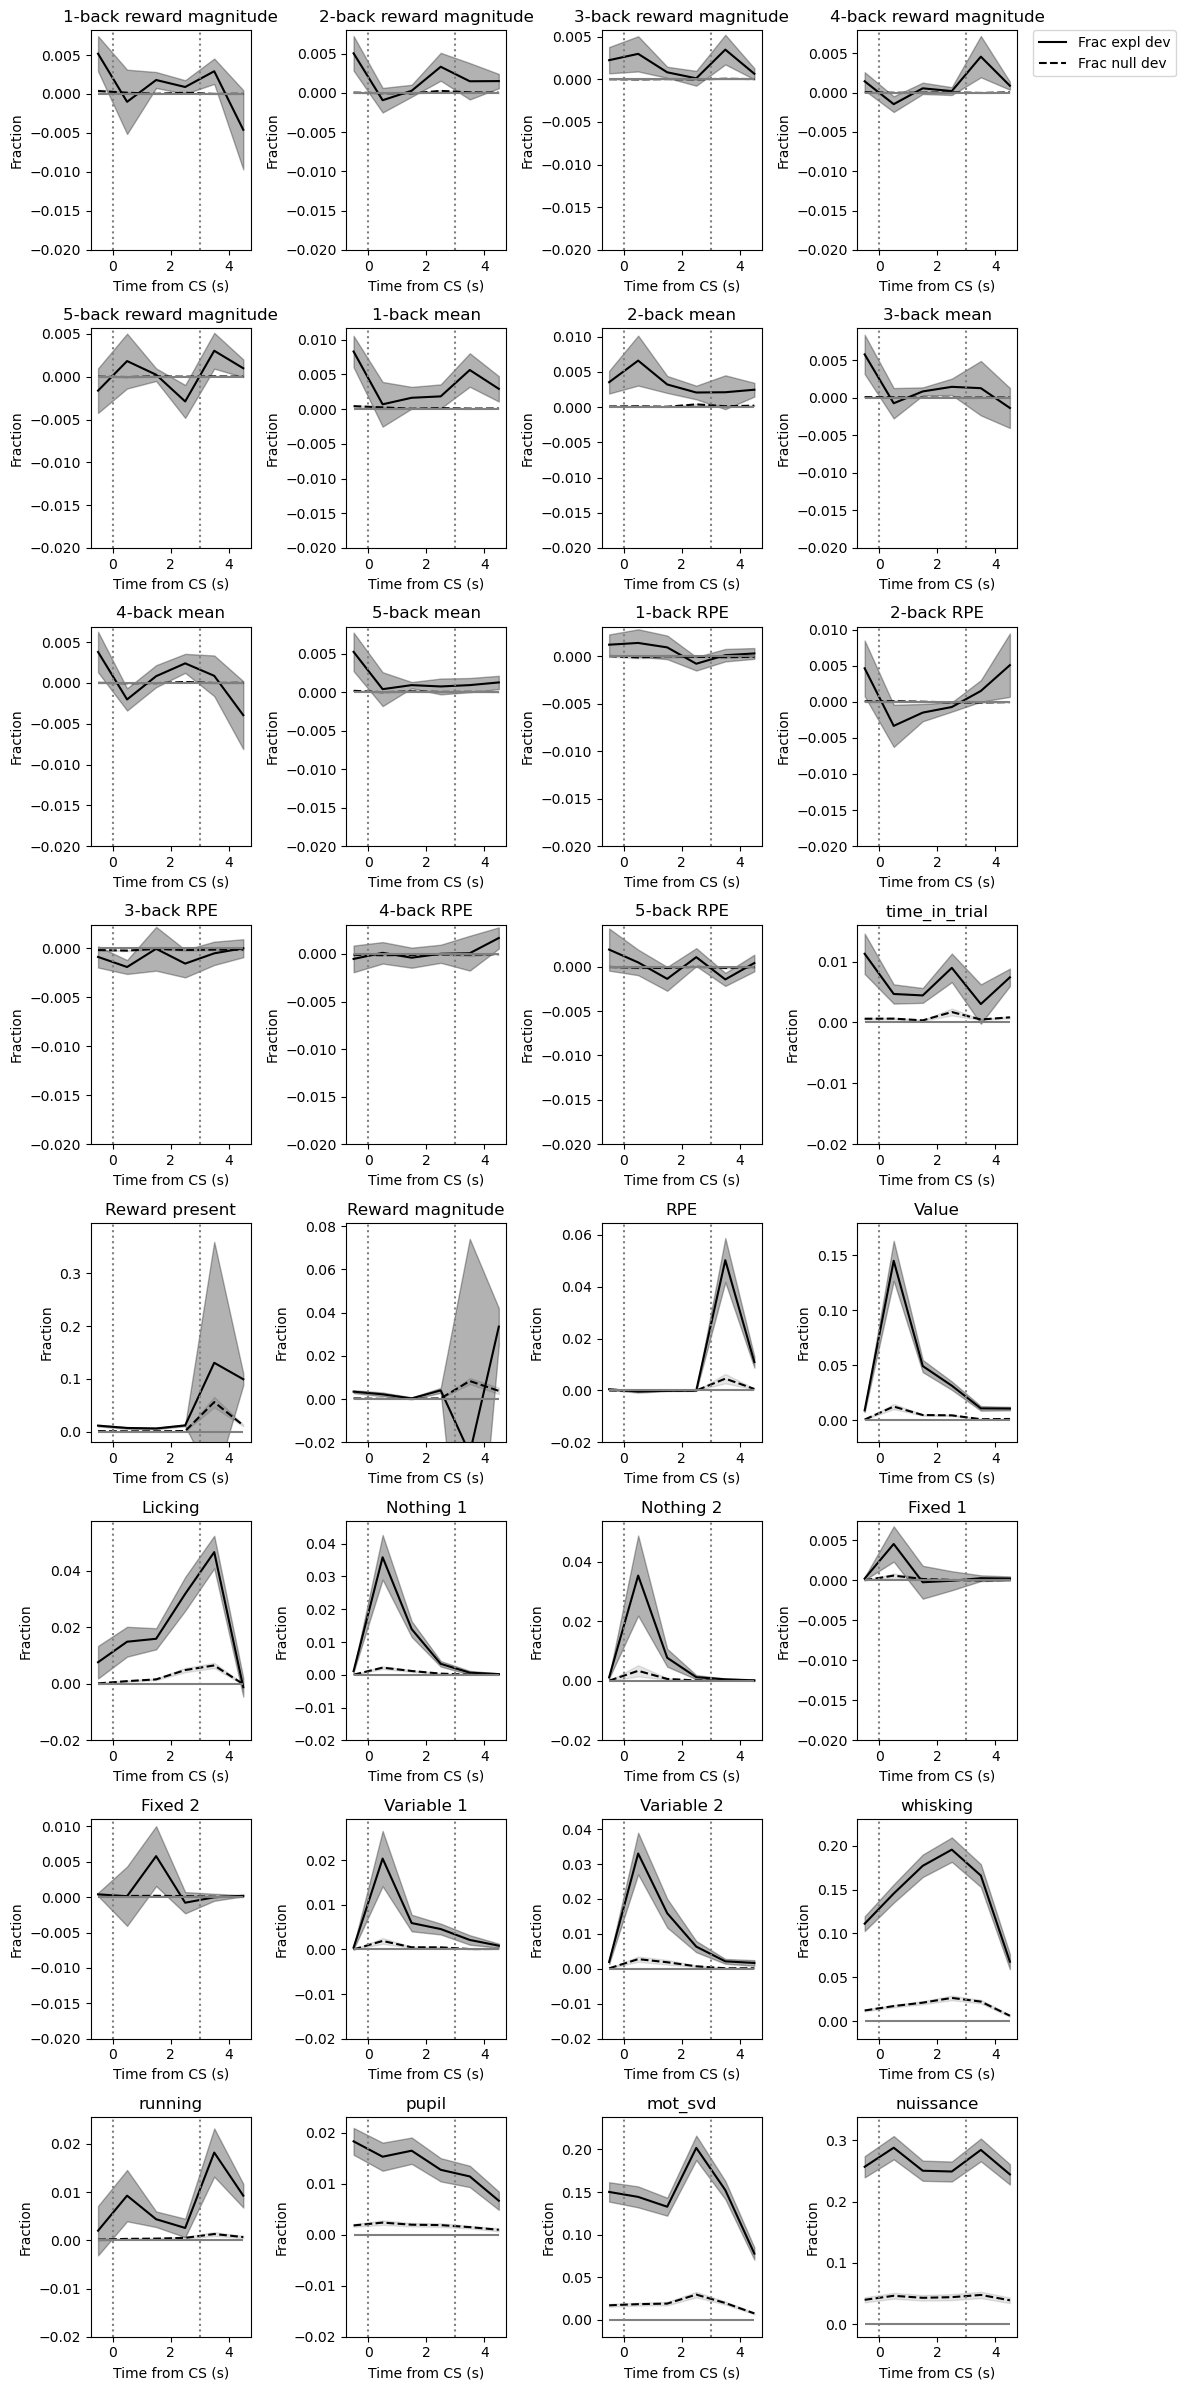

In [68]:
# Plot fraction explained deviance and fraction null deviance in time
fig, ax = plt.subplots(8,4,figsize=(12,24))
for i_var, this_name in enumerate(all_var):
    this_mean_expl = frac_expl_dev_tm[:,:,i_var].mean(axis=-1)
    this_sem_expl = frac_expl_dev_tm[:,:,i_var].std(axis=-1)/np.sqrt(n_cells)
    this_mean_null = frac_null_dev_tm[:,:,i_var].mean(axis=-1)
    this_sem_null = frac_null_dev_tm[:,:,i_var].std(axis=-1)/np.sqrt(n_cells)
    this_ax = ax[i_var//4,i_var%4]
    this_ax.plot(tm_centers, this_mean_expl,'k',label='Frac expl dev')
    this_ax.fill_between(tm_centers, this_mean_expl - this_sem_expl, this_mean_expl + this_sem_expl, color='k',alpha=0.3)
    this_ax.plot(tm_centers, this_mean_null,'k--',label='Frac null dev')
    this_ax.fill_between(tm_centers, this_mean_null - this_sem_null, this_mean_null + this_sem_null, color='k',alpha=0.1)
    this_ax.vlines([0,3], -0.02, 1.1*(this_mean_expl + this_sem_expl).max(), color='gray',ls=':')
    this_ax.hlines(0, -.5, 4.5, color='gray') 
    this_ax.set(xlabel='Time from CS (s)',ylabel='Fraction',title=this_name,
                ylim=[-0.02, 1.1*(this_mean_expl + this_sem_expl).max()])
    if i_var == 3:
        this_ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()

Note that one issue of model breakdown procedure is that Poisson GLM has a non-linear activation function, so the "breakdown" is not linear. If you add the fraction explained deviance of all variables together, it will not sum to one. One should interpret this value from model breakdown procedure with caution. If you perform model breadown procedure on a Gaussian model, it will be linear and you don't need to worry about this issue.

Here I only demonstrate model breakdown procedure on individual variables. Similarly, one can perform model breakdown procedure on groups of variables. For example, one can ablate all features related to past RPE and compute fraction null (or explained) deviance for this group as a whole. 

### Model comparison procedure with re-fitting for feature contribution

Another commonly used method to evaluate contribution of a predictor is through refitting the model without that predictor and compare the model performance of the original model (**"full model"**) and the model fitted without that particular predictor (**"reduced model"**), which we called "model comparison" procedure. One can compute the **fraction null deviance** in this case, which is equivalent to the change in model performance (measured in fraction deviance explained). (You may compute fraction explained deviance by normalizing with the explained deviance of the full model, but computing fraction null deviance might be more straightforward here.)

In [69]:
reduced = {}
reduce_vars = ['licking', 'expectiles']
for to_drop in reduce_vars:

    print(to_drop)

    # load regressor matrix
    with open(os.path.join(orig_figure_path, 'regress_drop_{}.p'.format(to_drop)), 'rb') as f:
        dat = pickle.load(f)

    # load results file
    pickle_path = os.path.join(orig_figure_path, 'regress_cells_drop_{}.p'.format(to_drop))
    with open(pickle_path, 'rb') as f:
        reduced[to_drop] = dill.load(f)

    for key in dat.keys():
        reduced[to_drop][key] = dat[key]
    

licking
value


In [70]:
for v1, v2 in zip(model.train_idx.values(), reduced['licking']['model'].train_idx.values()):
    print(np.all(v1 == v2))
for v1, v2 in zip(model.train_idx.values(), reduced['expectiles']['model'].train_idx.values()):
    print(np.all(v1 == v2))

True
True
True
True
True
True
True
True
True
True
True
True


After model fitting, selection and evaluation for the reduced model, we can compare the overall model performance (fraction deviance explained) on test data of the full model and reduced model when licking/value is removed from fitting. While many neurons are equivalent, only a few improve in the reduced model, and more decrease, indicating that licking/value contributed to the activity of those neurons.

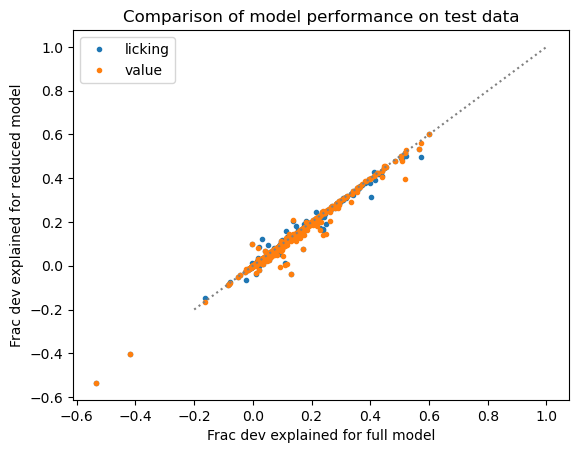

In [71]:
# Compare model performance of full vs. reduced model
for to_drop in reduce_vars:
    plt.plot(frac_dev_expl, reduced[to_drop]['frac_dev_expl'], '.', label=to_drop)
plt.plot([-0.2,1],[-0.2,1],'gray',ls=':')
plt.xlabel('Frac dev explained for full model')
plt.ylabel('Frac dev explained for reduced model')
plt.title('Comparison of model performance on test data')
plt.legend()

We can also compute the time binned fraction null deviance of cue by comparing the full model and reduced model. Same as the model breakdown procedure, here we evaluate the fraction null deviance on CV held-out data, which is 85% of the whole dataset.

Then we can visualize the time-binned fraction null deviance of licking/value from the model comparison procedure, and compare it to the model breakdown procedure

In [72]:
all_var

['1-back reward magnitude',
 '2-back reward magnitude',
 '3-back reward magnitude',
 '4-back reward magnitude',
 '5-back reward magnitude',
 '1-back mean',
 '2-back mean',
 '3-back mean',
 '4-back mean',
 '5-back mean',
 '1-back RPE',
 '2-back RPE',
 '3-back RPE',
 '4-back RPE',
 '5-back RPE',
 'time_in_trial',
 'Reward present',
 'Reward magnitude',
 'RPE',
 'Value',
 'Licking',
 'Nothing 1',
 'Nothing 2',
 'Fixed 1',
 'Fixed 2',
 'Variable 1',
 'Variable 2',
 'whisking',
 'running',
 'pupil',
 'mot_svd',
 'nuissance']

(72750, 529) (6, 529)
(72750, 529) (6, 529)


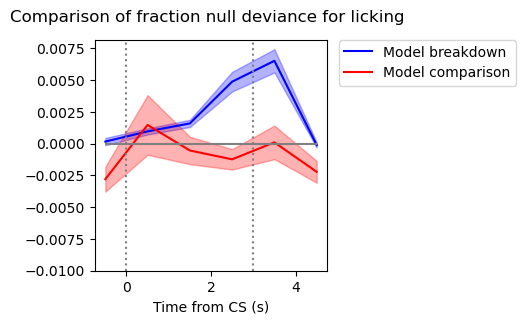

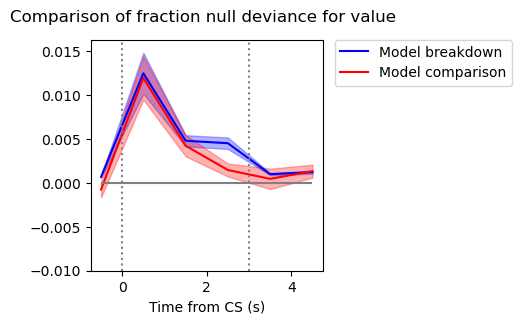

In [74]:
for to_drop in reduce_vars:
    
    # Make prediction of reduced model on CV held-out data
    pred_reduced_cv = reduced[to_drop]['model'].make_prediction_cv(reduced[to_drop]['X_train'])
    
    # Compute the pointwise model deviance of the reduced model
    model_dev_reduced = glm.pointwise_deviance(reduced[to_drop]['y_train'], pred_reduced_cv, loss_type = reduced[to_drop]['model'].loss_type)
    
    # Bin model deviance for reduced model into position and time bins
    model_dev_tm_reduced = tm_binning(model_dev_reduced, time_in_trial_train, tm_centers, tm_half_width)
    print(model_dev_reduced.shape, model_dev_tm_reduced.shape)
    
    # Compute differences in model deviance for full and reduced model and then normalize by average null deviance 
    # i.e. "fraction null deviance" for model comparison
    diff_frac_null_dev_tm = (model_dev_tm_reduced - model_dev_tm)/null_dev_avg[np.newaxis,:]

    ## Compare fraction null deviance of cue for model breakdwon vs. model comparison procedure
    drop_ind = all_var.index(to_drop.capitalize())
    fig, ax = plt.subplots(1,1,figsize=(3,3)) 
    
    # Plot feedback/ITI
    this_mean_tm_mb = frac_null_dev_tm[:,:,drop_ind].mean(axis=-1)
    this_sem_tm_mb = frac_null_dev_tm[:,:,drop_ind].std(axis=-1)/np.sqrt(n_cells)
    this_mean_tm_mc = diff_frac_null_dev_tm.mean(axis=-1)
    this_sem_tm_mc = diff_frac_null_dev_tm.std(axis=-1)/np.sqrt(n_cells)
    ax.plot(tm_centers, this_mean_tm_mb, 'b', label='Model breakdown')
    ax.fill_between(tm_centers, this_mean_tm_mb - this_sem_tm_mb, this_mean_tm_mb + this_sem_tm_mb, color='b',alpha=0.3)
    ax.plot(tm_centers, this_mean_tm_mc, 'r', label='Model comparison')
    ax.fill_between(tm_centers, this_mean_tm_mc - this_sem_tm_mc, this_mean_tm_mc + this_sem_tm_mc, color='r',alpha=0.3)
    ymax = np.max([(this_mean_tm_mc + this_sem_tm_mc).max(), (this_mean_tm_mb + this_sem_tm_mb).max()])
    ax.vlines([0,3], -0.01, 1.1*ymax, color='gray', ls=':')
    ax.hlines(0, -.5, 4.5, color='gray')
    ax.set(xlabel='Time from CS (s)', ylabel='',
              ylim=[-0.01, 1.1*ymax])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    fig.suptitle(f'Comparison of fraction null deviance for {to_drop}');

Note that they follow quite similar time courses. Surprisingly, for this case, the magnitude of fraction null deviance from model comparison procedure appears to be slightly greater than that from model breakdown procedure.

### Comparison of methods

To wrap up, it is everyone's choice of to use these three methods. Here is a summary of the pros and cons of each method. But overall, these methods are complementary to each other, and should give you consistent results in qualitative ways.

**Model weights**:
- Should be interpreted as "multiplicative factors" of neural activity
- Provide information for both magnitude and directionality of tuning
- Robust to differences in baseline response
- Difficult to interpret the magnitude when comparing across variables

**Model breakdown procedure (for fraction null deviance and fraction explained deviance)**:
- The metrics are easy to interpret and compare across variables
- Does not tell you the directionality of tuning
- Does not require re-fitting the model (fast to do)
- It's not a linear breakdown for Poisson GLMs, but linear for Gaussian
- Can be less biased in assigning contribution of correlated variables, if the model is not terribly mis-specified

**Model comparison procedure with re-fitting (for fraction null deviance)**:
- The metric is easy to interpret and compare across variables
- Does not tell you the directionality of tuning
- Require re-fitting of a model for each variable (computationally demanding)
- Extract the "unique" portion of deviance explained, can be biased (and underestimate the contribution of a variable) when there are correlated variables and you don't know which is actually contributing to response

# References

- Tseng, S.-Y., Chettih, S.N., Arlt, C., Barroso-Luque, R., and Harvey, C.D. (2022). Shared and specialized coding across posterior cortical areas for dynamic navigation decisions. Neuron 110, 2484–2502.e16.

- Minderer, M., Brown, K.D., and Harvey, C.D. (2019). The spatial structure of neural encoding in mouse posterior cortex during navigation. Neuron 102, 232–248.e11.

- Pillow, J.W., Shlens, J., Paninski, L., Sher, A., Litke, A.M., Chichilnisky, E.J., and Simoncelli, E.P. (2008). Spatio-temporal correlations and visual signalling in a complete neuronal population. Nature 454, 995–999.

This notebook is entirely adapted from [Shih-Yi Tseng](https://github.com/HarveyLab/GLM_Tensorflow_2/blob/main/tutorial/Tutorial_for_fitting_neural_calcium_imaging_data_with_GLM.ipynb)